In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
device = torch.device("cuda:2")
#device = 'cpu'
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import numpy as np

In [3]:
df = pd.read_csv("Imbalanced.csv")
df.head()

,Tweet,Label
0,I love finding out who your true friends are. ...,0
1,USER :/ bye,0
2,USER I absolutely love Kanye's voice USER,0
3,We're hiring a new Kiosk Supervisor! Think you...,0
4,Every time I see Dave Grohl with his long hipp...,0


In [6]:
df = df[['Tweet', 'Label']]

In [8]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Tweet'], df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['Label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model1 = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
model2 = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

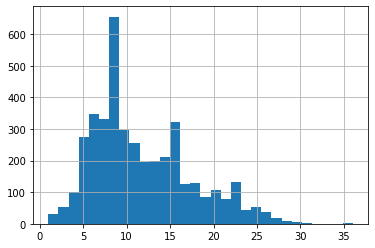

In [12]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [13]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
for param in model1.parameters():
    param.requires_grad = False

In [17]:
for param in model2.parameters():
    param.requires_grad = False

In [13]:
# class BERT_Arch(nn.Module):

#     def __init__(self, bert):
      
#       super(BERT_Arch, self).__init__()

#       self.bert = bert 
      
#       self.dropout = nn.Dropout(0.1)
      
#       self.relu =  nn.ReLU()

#       self.fc1 = nn.Linear(768,512)
     
#       self.fc2 = nn.Linear(512,2)

#       self.softmax = nn.LogSoftmax(dim=1)

   
#     def forward(self, sent_id, mask):
#       #print(sent_id)
#       #print(mask)
 
#       _, cls_hs = self.bert(sent_id, mask)[:2]
      
#       x = self.fc1(cls_hs)

#       x = self.relu(x)

#       x = self.dropout(x)

#       x = self.fc2(x)
      
#       x = self.softmax(x)
#       print(x)

#       return x

In [14]:
# class ROBERT_Arch(nn.Module):

#     def __init__(self, robert):
      
#       super(ROBERT_Arch, self).__init__()

#       self.robert = robert 
      
#       self.dropout = nn.Dropout(0.1)
      
#       self.relu =  nn.ReLU()

     
#       self.fc1 = nn.Linear(768,2)
      
#       #self.fc2 = nn.Linear(512,2)

#       #self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, sent_id, mask):
 
#       _, cls_hs = self.robert(sent_id, mask)[:2]
      
#       x = self.fc1(cls_hs)

#       x = self.relu(x)

#       #x = self.dropout(x)

#       #x = self.fc2(x)

# #       x = self.softmax(x)
#       print(x.shape)
#       return x

In [15]:
# model2 = BERT_Arch(model2)

# model2 = model2.to(device)

In [16]:
# model1 = ROBERT_Arch(model1)

# model1 = model1.to(device)

In [18]:
print(model1)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [19]:
class Ensemble(nn.Module):

    def __init__(self, model1, model2):
      
      super(Ensemble, self).__init__()

      self.model1 = model1
    
      self.model2 = model2
      
      self.dropout = nn.Dropout(0.1)
      
      self.relu =  nn.ReLU()

     
      self.fc1 = nn.Linear(768,512)
      
      self.fc2 = nn.Linear(512,2)

      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
 
      _, cls_hs1 = self.model1(sent_id, mask)[:2]
      
      #print('----------------------------------------------')
    
      _, cls_hs2 = self.model2(sent_id, mask)[:2]
      
      #print(cls_hs1.shape)
      #print(cls_hs2.shape)
        #cls_hs = np.mean(np.array([cls_hs1,cls_hs2]),axis=0)
      #cls_hs = cls_hs1.add(cls_hs2)
      #cls_hs = torch.mean(cls_hs)
      cls_hs = (cls_hs1 + cls_hs2) / 2
      #print(cls_hs)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc2(x)

      x = self.softmax(x)

      return x

In [20]:
ensemble = Ensemble(model1,model2)

In [21]:
ensemble = ensemble.to(device)

In [22]:
from transformers import AdamW

optimizer = AdamW(model1.parameters(),
                  lr = 1e-5) 

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.64075696 2.27611111]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=2944    0
3822    1
1828    0
1066    0
377     0
       ..
120     0
999     0
2188    0
4146    1
568     0
Name: Label, Length: 4097, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [24]:
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights) 

epochs = 10

In [25]:
def train():
  
  ensemble.train()

  total_loss, total_accuracy = 0, 0
  
  total_preds=[]
 
  for step,batch in enumerate(train_dataloader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    #print(sent_id)
#     sent_id = sent_id + 0.0001
#     mask = mask + 0.0001
    #print(mask)
    #print(mask * sent_id)
    
   
    ensemble.zero_grad()        

    preds = ensemble(sent_id, mask)
    print(preds)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(ensemble.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  
  total_preds  = np.concatenate(total_preds, axis=0)

  
  return avg_loss, total_preds

In [26]:
def evaluate():
  
  print("\nEvaluating...")
 
  ensemble.eval()

  total_loss, total_accuracy = 0, 0
  
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    

    if step % 50 == 0 and not step == 0:
      
            
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    
    
    with torch.no_grad():
     
      preds = ensemble(sent_id, mask)

      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  
  avg_loss = total_loss / len(val_dataloader) 

 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [27]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    

    train_loss, _ = train()
    
   
    valid_loss, _ = evaluate()
    
   
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(ensemble.state_dict(), 'saved_weights.pt')
    

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
tensor([[-0.5754, -0.8266],
        [-0.6452, -0.7435],
        [-0.6038, -0.7913],
        [-0.5926, -0.8049],
        [-0.6404, -0.7489],
        [-0.6175, -0.7750],
        [-0.6152, -0.7777],
        [-0.5852, -0.8142]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6347, -0.7552],
        [-0.6595, -0.7279],
        [-0.6034, -0.7917],
        [-0.5986, -0.7976],
        [-0.6142, -0.7788],
        [-0.5763, -0.8254],
        [-0.6179, -0.7745],
        [-0.6415, -0.7476]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5740, -0.8285],
        [-0.5933, -0.8041],
        [-0.6616, -0.7257],
        [-0.5764, -0.8254],
        [-0.6732, -0.7135],
        [-0.5992, -0.7968],
        [-0.6586, -0.7289],
        [-0.5463, -0.8653]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5685, -0.8356],
        [-0.6287, -0.7621],
        [-0.7123, -0.6744],
        [-0.5619, -0.8443],
        [-0.6211, -0.7708],
        [-0.5899, -0.8083],
 

tensor([[-0.6037, -0.7914],
        [-0.6291, -0.7615],
        [-0.5955, -0.8013],
        [-0.5882, -0.8105],
        [-0.6071, -0.7873],
        [-0.5735, -0.8291],
        [-0.5857, -0.8135],
        [-0.5764, -0.8253]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5446, -0.8677],
        [-0.6241, -0.7674],
        [-0.6672, -0.7197],
        [-0.6706, -0.7162],
        [-0.5829, -0.8170],
        [-0.5829, -0.8171],
        [-0.6205, -0.7714],
        [-0.5754, -0.8266]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6355, -0.7543],
        [-0.6951, -0.6912],
        [-0.6237, -0.7678],
        [-0.6295, -0.7611],
        [-0.5773, -0.8242],
        [-0.6142, -0.7789],
        [-0.5848, -0.8147],
        [-0.6383, -0.7512]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6194, -0.7728],
        [-0.6162, -0.7765],
        [-0.6163, -0.7764],
        [-0.5956, -0.8013],
        [-0.5638, -0.8418],
        [-0.6548, -0.7331],
        [-0.6147

tensor([[-0.6172, -0.7754],
        [-0.6406, -0.7486],
        [-0.5122, -0.9142],
        [-0.5423, -0.8709],
        [-0.5425, -0.8706],
        [-0.5477, -0.8634],
        [-0.5664, -0.8383],
        [-0.5796, -0.8213]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6916, -0.6947],
        [-0.6188, -0.7734],
        [-0.5740, -0.8284],
        [-0.5875, -0.8113],
        [-0.5978, -0.7985],
        [-0.6547, -0.7332],
        [-0.6769, -0.7097],
        [-0.6322, -0.7580]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6686, -0.7183],
        [-0.5682, -0.8360],
        [-0.6317, -0.7586],
        [-0.6180, -0.7744],
        [-0.6418, -0.7473],
        [-0.6203, -0.7718],
        [-0.5771, -0.8245],
        [-0.6426, -0.7463]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5758, -0.8261],
        [-0.6754, -0.7112],
        [-0.6722, -0.7145],
        [-0.6155, -0.7773],
        [-0.6449, -0.7439],
        [-0.6540, -0.7339],
        [-0.6918

tensor([[-0.6472, -0.7414],
        [-0.6632, -0.7240],
        [-0.6283, -0.7625],
        [-0.6244, -0.7669],
        [-0.6703, -0.7165],
        [-0.5992, -0.7968],
        [-0.6547, -0.7331],
        [-0.5936, -0.8037]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6087, -0.7854],
        [-0.6225, -0.7692],
        [-0.6122, -0.7812],
        [-0.6030, -0.7922],
        [-0.5791, -0.8219],
        [-0.6532, -0.7348],
        [-0.5868, -0.8121],
        [-0.6138, -0.7793]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6310, -0.7594],
        [-0.6275, -0.7634],
        [-0.6048, -0.7901],
        [-0.5673, -0.8372],
        [-0.5551, -0.8533],
        [-0.6363, -0.7534],
        [-0.6699, -0.7170],
        [-0.5588, -0.8484]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5509, -0.8591],
        [-0.6161, -0.7766],
        [-0.5707, -0.8327],
        [-0.6517, -0.7364],
        [-0.6441, -0.7448],
        [-0.5953, -0.8017],
        [-0.5736

tensor([[-0.6454, -0.7433],
        [-0.5831, -0.8168],
        [-0.5932, -0.8042],
        [-0.5765, -0.8253],
        [-0.6426, -0.7464],
        [-0.6255, -0.7657],
        [-0.5852, -0.8142],
        [-0.6248, -0.7665]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6903, -0.6960],
        [-0.5882, -0.8104],
        [-0.5684, -0.8357],
        [-0.6048, -0.7900],
        [-0.6003, -0.7956],
        [-0.5678, -0.8364],
        [-0.6123, -0.7811],
        [-0.6249, -0.7663]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6205, -0.7715],
        [-0.6129, -0.7804],
        [-0.6147, -0.7783],
        [-0.6310, -0.7594],
        [-0.6285, -0.7623],
        [-0.6252, -0.7660],
        [-0.6240, -0.7674],
        [-0.6524, -0.7357]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5848, -0.8147],
        [-0.6250, -0.7662],
        [-0.5894, -0.8090],
        [-0.6141, -0.7789],
        [-0.5728, -0.8299],
        [-0.6401, -0.7491],
        [-0.6422

tensor([[-0.6913, -0.6950],
        [-0.6404, -0.7488],
        [-0.6314, -0.7589],
        [-0.6061, -0.7885],
        [-0.6659, -0.7212],
        [-0.6872, -0.6991],
        [-0.6014, -0.7941],
        [-0.6668, -0.7202]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6091, -0.7850],
        [-0.6497, -0.7386],
        [-0.5532, -0.8559],
        [-0.6570, -0.7306],
        [-0.6794, -0.7071],
        [-0.5834, -0.8164],
        [-0.6156, -0.7772],
        [-0.6278, -0.7631]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5969, -0.7996],
        [-0.5514, -0.8583],
        [-0.5480, -0.8630],
        [-0.5550, -0.8535],
        [-0.6348, -0.7551],
        [-0.5645, -0.8409],
        [-0.6052, -0.7896],
        [-0.5573, -0.8504]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6385, -0.7510],
        [-0.6697, -0.7171],
        [-0.6063, -0.7883],
        [-0.6569, -0.7308],
        [-0.6193, -0.7728],
        [-0.5718, -0.8313],
        [-0.6354

tensor([[-0.6001, -0.7957],
        [-0.6021, -0.7934],
        [-0.5846, -0.8150],
        [-0.5718, -0.8313],
        [-0.5946, -0.8025],
        [-0.6551, -0.7327],
        [-0.6177, -0.7748],
        [-0.5858, -0.8135]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6214, -0.7704],
        [-0.5928, -0.8047],
        [-0.5320, -0.8854],
        [-0.5803, -0.8204],
        [-0.5460, -0.8657],
        [-0.5946, -0.8025],
        [-0.5679, -0.8364],
        [-0.5748, -0.8274]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6342, -0.7558],
        [-0.6262, -0.7649],
        [-0.5512, -0.8587],
        [-0.6255, -0.7657],
        [-0.6300, -0.7606],
        [-0.5656, -0.8393],
        [-0.5632, -0.8425],
        [-0.6995, -0.6868]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6335, -0.7566],
        [-0.5656, -0.8393],
        [-0.5405, -0.8734],
        [-0.6173, -0.7752],
        [-0.6608, -0.7265],
        [-0.5546, -0.8540],
        [-0.5717

tensor([[-0.6342, -0.7558],
        [-0.6079, -0.7864],
        [-0.6026, -0.7927],
        [-0.5951, -0.8018],
        [-0.5883, -0.8103],
        [-0.5827, -0.8173],
        [-0.6435, -0.7454],
        [-0.6384, -0.7511]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6257, -0.7654],
        [-0.6352, -0.7547],
        [-0.6026, -0.7928],
        [-0.5903, -0.8078],
        [-0.5725, -0.8304],
        [-0.6583, -0.7293],
        [-0.6289, -0.7619],
        [-0.5955, -0.8014]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5593, -0.8477],
        [-0.5907, -0.8074],
        [-0.6578, -0.7298],
        [-0.5497, -0.8607],
        [-0.6124, -0.7810],
        [-0.5920, -0.8057],
        [-0.6195, -0.7727],
        [-0.6086, -0.7855]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6170, -0.7756],
        [-0.6799, -0.7066],
        [-0.5795, -0.8214],
        [-0.6072, -0.7872],
        [-0.6170, -0.7756],
        [-0.5475, -0.8637],
        [-0.6241

tensor([[-0.6340, -0.7560],
        [-0.6056, -0.7891],
        [-0.5711, -0.8322],
        [-0.5570, -0.8509],
        [-0.5950, -0.8020],
        [-0.6782, -0.7083],
        [-0.5909, -0.8070],
        [-0.5924, -0.8052]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6787, -0.7078],
        [-0.5888, -0.8096],
        [-0.5722, -0.8307],
        [-0.5849, -0.8145],
        [-0.6381, -0.7515],
        [-0.6002, -0.7956],
        [-0.6243, -0.7671],
        [-0.6301, -0.7605]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6278, -0.7630],
        [-0.5764, -0.8253],
        [-0.6078, -0.7865],
        [-0.5655, -0.8394],
        [-0.5769, -0.8247],
        [-0.6696, -0.7173],
        [-0.6081, -0.7861],
        [-0.6311, -0.7593]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6266, -0.7645],
        [-0.5981, -0.7982],
        [-0.5761, -0.8257],
        [-0.5384, -0.8763],
        [-0.6572, -0.7305],
        [-0.6384, -0.7510],
        [-0.6050

tensor([[-0.5706, -0.8328],
        [-0.5494, -0.8611],
        [-0.5323, -0.8850],
        [-0.5667, -0.8379],
        [-0.5712, -0.8321],
        [-0.5837, -0.8161],
        [-0.5559, -0.8522],
        [-0.6583, -0.7293]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5611, -0.8453],
        [-0.5457, -0.8662],
        [-0.5947, -0.8024],
        [-0.6093, -0.7847],
        [-0.6825, -0.7039],
        [-0.5917, -0.8061],
        [-0.6459, -0.7427],
        [-0.6005, -0.7952]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6076, -0.7866],
        [-0.5513, -0.8584],
        [-0.7217, -0.6654],
        [-0.5956, -0.8013],
        [-0.5921, -0.8056],
        [-0.6568, -0.7309],
        [-0.6359, -0.7539],
        [-0.6350, -0.7549]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6091, -0.7850],
        [-0.6030, -0.7922],
        [-0.5681, -0.8361],
        [-0.6650, -0.7221],
        [-0.6374, -0.7522],
        [-0.6057, -0.7890],
        [-0.6844

tensor([[-0.5782, -0.8230],
        [-0.6401, -0.7491],
        [-0.6573, -0.7303],
        [-0.6364, -0.7533],
        [-0.6015, -0.7940],
        [-0.6010, -0.7947],
        [-0.5897, -0.8086],
        [-0.5234, -0.8977]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5580, -0.8494],
        [-0.6107, -0.7831],
        [-0.6108, -0.7828],
        [-0.6034, -0.7917],
        [-0.5516, -0.8581],
        [-0.6718, -0.7149],
        [-0.6244, -0.7669],
        [-0.6124, -0.7809]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6149, -0.7781],
        [-0.6679, -0.7191],
        [-0.6404, -0.7488],
        [-0.5748, -0.8274],
        [-0.6242, -0.7672],
        [-0.6208, -0.7712],
        [-0.6433, -0.7456],
        [-0.6276, -0.7633]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5853, -0.8140],
        [-0.6655, -0.7216],
        [-0.6554, -0.7324],
        [-0.6156, -0.7772],
        [-0.6164, -0.7763],
        [-0.5882, -0.8105],
        [-0.6646

tensor([[-0.5821, -0.8181],
        [-0.6046, -0.7903],
        [-0.5719, -0.8311],
        [-0.5713, -0.8319],
        [-0.6193, -0.7729],
        [-0.5660, -0.8388],
        [-0.6008, -0.7949],
        [-0.6490, -0.7394]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6255, -0.7657],
        [-0.6626, -0.7247],
        [-0.6275, -0.7635],
        [-0.5520, -0.8576],
        [-0.6293, -0.7613],
        [-0.6201, -0.7720],
        [-0.6271, -0.7639],
        [-0.5736, -0.8290]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6062, -0.7884],
        [-0.6425, -0.7465],
        [-0.6004, -0.7954],
        [-0.6219, -0.7699],
        [-0.5798, -0.8210],
        [-0.5746, -0.8277],
        [-0.5767, -0.8249],
        [-0.6214, -0.7705]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5503, -0.8598],
        [-0.6390, -0.7503],
        [-0.6340, -0.7561],
        [-0.6332, -0.7569],
        [-0.5812, -0.8192],
        [-0.6679, -0.7190],
        [-0.6190

tensor([[-0.5930, -0.8045],
        [-0.6498, -0.7385],
        [-0.6141, -0.7790],
        [-0.6507, -0.7375],
        [-0.6260, -0.7651],
        [-0.5637, -0.8419],
        [-0.6784, -0.7082],
        [-0.6743, -0.7124]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6828, -0.7036],
        [-0.6135, -0.7797],
        [-0.6299, -0.7607],
        [-0.5982, -0.7981],
        [-0.5817, -0.8186],
        [-0.6221, -0.7696],
        [-0.6366, -0.7531],
        [-0.6230, -0.7686]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6169, -0.7756],
        [-0.5823, -0.8178],
        [-0.5921, -0.8056],
        [-0.6508, -0.7373],
        [-0.5945, -0.8026],
        [-0.6800, -0.7065],
        [-0.6013, -0.7943],
        [-0.6688, -0.7181]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6173, -0.7752],
        [-0.5854, -0.8139],
        [-0.6191, -0.7731],
        [-0.5700, -0.8336],
        [-0.5793, -0.8216],
        [-0.5398, -0.8744],
        [-0.6687

tensor([[-0.6047, -0.7902],
        [-0.6172, -0.7753],
        [-0.6287, -0.7621],
        [-0.6540, -0.7339],
        [-0.6410, -0.7481],
        [-0.5280, -0.8911],
        [-0.6573, -0.7303],
        [-0.6087, -0.7854]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5819, -0.8183],
        [-0.5833, -0.8165],
        [-0.6092, -0.7848],
        [-0.5496, -0.8609],
        [-0.5955, -0.8014],
        [-0.5883, -0.8103],
        [-0.6006, -0.7952],
        [-0.5924, -0.8052]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6063, -0.7883],
        [-0.5971, -0.7994],
        [-0.6372, -0.7524],
        [-0.5933, -0.8040],
        [-0.6347, -0.7552],
        [-0.6242, -0.7672],
        [-0.6028, -0.7924],
        [-0.6696, -0.7173]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5550, -0.8534],
        [-0.6269, -0.7641],
        [-0.5576, -0.8500],
        [-0.5270, -0.8925],
        [-0.5365, -0.8790],
        [-0.6554, -0.7324],
        [-0.6274

tensor([[-0.6979, -0.6884],
        [-0.6392, -0.7502],
        [-0.5866, -0.8124],
        [-0.6450, -0.7438],
        [-0.6579, -0.7297],
        [-0.5816, -0.8187],
        [-0.6337, -0.7564],
        [-0.6182, -0.7742]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6330, -0.7571],
        [-0.5778, -0.8236],
        [-0.6668, -0.7202],
        [-0.6255, -0.7657],
        [-0.5857, -0.8136],
        [-0.6034, -0.7917],
        [-0.5940, -0.8032],
        [-0.5648, -0.8404]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5865, -0.8126],
        [-0.5987, -0.7974],
        [-0.7005, -0.6859],
        [-0.5735, -0.8290],
        [-0.5817, -0.8186],
        [-0.5659, -0.8389],
        [-0.6144, -0.7786],
        [-0.6059, -0.7887]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6359, -0.7539],
        [-0.5015, -0.9305],
        [-0.6283, -0.7625],
        [-0.6005, -0.7953],
        [-0.6152, -0.7777],
        [-0.6174, -0.7751],
        [-0.5750

tensor([[-0.6882, -0.6981],
        [-0.6022, -0.7933],
        [-0.5611, -0.8454],
        [-0.6147, -0.7783],
        [-0.6170, -0.7756],
        [-0.6736, -0.7131],
        [-0.6756, -0.7110],
        [-0.5798, -0.8210]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6092, -0.7848],
        [-0.6010, -0.7946],
        [-0.6099, -0.7840],
        [-0.5764, -0.8254],
        [-0.5744, -0.8280],
        [-0.6135, -0.7797],
        [-0.6119, -0.7816],
        [-0.6339, -0.7561]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6100, -0.7838],
        [-0.5682, -0.8359],
        [-0.6233, -0.7683],
        [-0.6115, -0.7820],
        [-0.6324, -0.7579],
        [-0.6447, -0.7440],
        [-0.6383, -0.7511],
        [-0.6075, -0.7869]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5696, -0.8341],
        [-0.5860, -0.8131],
        [-0.5678, -0.8365],
        [-0.5761, -0.8257],
        [-0.6135, -0.7797],
        [-0.5590, -0.8481],
        [-0.5766

tensor([[-0.5682, -0.8359],
        [-0.5910, -0.8069],
        [-0.6292, -0.7614],
        [-0.5573, -0.8503],
        [-0.6211, -0.7707],
        [-0.5874, -0.8114],
        [-0.6079, -0.7864],
        [-0.6035, -0.7916]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5504, -0.8597],
        [-0.5801, -0.8206],
        [-0.5863, -0.8128],
        [-0.6380, -0.7516],
        [-0.6193, -0.7729],
        [-0.7121, -0.6745],
        [-0.5456, -0.8663],
        [-0.6182, -0.7742]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5565, -0.8515],
        [-0.6318, -0.7585],
        [-0.6509, -0.7372],
        [-0.6386, -0.7508],
        [-0.5950, -0.8020],
        [-0.5925, -0.8051],
        [-0.6229, -0.7687],
        [-0.6439, -0.7450]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6769, -0.7097],
        [-0.5672, -0.8373],
        [-0.5205, -0.9019],
        [-0.6084, -0.7857],
        [-0.6474, -0.7411],
        [-0.5743, -0.8280],
        [-0.5837

tensor([[-0.6728, -0.7139],
        [-0.6053, -0.7895],
        [-0.6103, -0.7834],
        [-0.6269, -0.7641],
        [-0.6384, -0.7511],
        [-0.6408, -0.7484],
        [-0.6414, -0.7478],
        [-0.6560, -0.7318]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6176, -0.7749],
        [-0.6134, -0.7798],
        [-0.5959, -0.8009],
        [-0.6366, -0.7531],
        [-0.5886, -0.8099],
        [-0.6249, -0.7664],
        [-0.6378, -0.7518],
        [-0.6429, -0.7461]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   100  of    513.
tensor([[-0.5684, -0.8358],
        [-0.6054, -0.7894],
        [-0.6131, -0.7802],
        [-0.5782, -0.8231],
        [-0.5780, -0.8233],
        [-0.6314, -0.7590],
        [-0.5635, -0.8421],
        [-0.6415, -0.7476]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6266, -0.7645],
        [-0.6102, -0.7836],
        [-0.5924, -0.8052],
        [-0.5777, -0.8237],
        [-0.5863, -0.8127],
        [-0.5974, 

tensor([[-0.6317, -0.7586],
        [-0.5912, -0.8067],
        [-0.6333, -0.7568],
        [-0.6134, -0.7798],
        [-0.6356, -0.7542],
        [-0.5799, -0.8209],
        [-0.5688, -0.8352],
        [-0.5834, -0.8165]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6083, -0.7859],
        [-0.6730, -0.7137],
        [-0.5828, -0.8172],
        [-0.5795, -0.8214],
        [-0.6334, -0.7566],
        [-0.5755, -0.8266],
        [-0.6844, -0.7020],
        [-0.6102, -0.7836]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6310, -0.7594],
        [-0.6082, -0.7860],
        [-0.5889, -0.8096],
        [-0.5978, -0.7985],
        [-0.5764, -0.8254],
        [-0.5897, -0.8085],
        [-0.6271, -0.7639],
        [-0.6516, -0.7365]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5796, -0.8212],
        [-0.6441, -0.7448],
        [-0.5943, -0.8029],
        [-0.5829, -0.8171],
        [-0.6398, -0.7495],
        [-0.6439, -0.7449],
        [-0.6036

tensor([[-0.5547, -0.8539],
        [-0.6180, -0.7744],
        [-0.6457, -0.7429],
        [-0.6219, -0.7699],
        [-0.6292, -0.7614],
        [-0.5977, -0.7987],
        [-0.6434, -0.7454],
        [-0.6467, -0.7418]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6201, -0.7719],
        [-0.5472, -0.8641],
        [-0.5784, -0.8228],
        [-0.5784, -0.8228],
        [-0.6004, -0.7954],
        [-0.6506, -0.7376],
        [-0.5813, -0.8191],
        [-0.5933, -0.8040]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6537, -0.7342],
        [-0.5646, -0.8407],
        [-0.6551, -0.7327],
        [-0.6288, -0.7619],
        [-0.5975, -0.7989],
        [-0.6337, -0.7563],
        [-0.5635, -0.8421],
        [-0.5927, -0.8049]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5819, -0.8183],
        [-0.6266, -0.7644],
        [-0.5993, -0.7967],
        [-0.6501, -0.7381],
        [-0.5482, -0.8628],
        [-0.5574, -0.8503],
        [-0.5578

tensor([[-0.5611, -0.8453],
        [-0.5775, -0.8240],
        [-0.6216, -0.7702],
        [-0.6133, -0.7799],
        [-0.6378, -0.7517],
        [-0.5655, -0.8395],
        [-0.5663, -0.8384],
        [-0.6011, -0.7946]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5937, -0.8036],
        [-0.6623, -0.7250],
        [-0.6125, -0.7809],
        [-0.5971, -0.7995],
        [-0.5875, -0.8113],
        [-0.6848, -0.7015],
        [-0.5281, -0.8910],
        [-0.5810, -0.8195]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5993, -0.7967],
        [-0.6428, -0.7462],
        [-0.6523, -0.7358],
        [-0.6264, -0.7647],
        [-0.5405, -0.8734],
        [-0.6471, -0.7414],
        [-0.5684, -0.8358],
        [-0.6389, -0.7506]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6139, -0.7792],
        [-0.5569, -0.8509],
        [-0.6592, -0.7283],
        [-0.6419, -0.7471],
        [-0.6366, -0.7531],
        [-0.6127, -0.7806],
        [-0.6278

tensor([[-0.6768, -0.7098],
        [-0.5840, -0.8157],
        [-0.5621, -0.8440],
        [-0.5940, -0.8032],
        [-0.5963, -0.8004],
        [-0.5913, -0.8065],
        [-0.5792, -0.8217],
        [-0.5654, -0.8396]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6409, -0.7482],
        [-0.6674, -0.7196],
        [-0.6140, -0.7791],
        [-0.6104, -0.7834],
        [-0.6155, -0.7773],
        [-0.6144, -0.7787],
        [-0.5499, -0.8603],
        [-0.5972, -0.7992]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5894, -0.8089],
        [-0.5398, -0.8744],
        [-0.6018, -0.7937],
        [-0.5722, -0.8308],
        [-0.5891, -0.8093],
        [-0.6297, -0.7609],
        [-0.5787, -0.8224],
        [-0.6450, -0.7437]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5933, -0.8041],
        [-0.5725, -0.8304],
        [-0.5873, -0.8115],
        [-0.6153, -0.7776],
        [-0.5822, -0.8180],
        [-0.5595, -0.8474],
        [-0.5824

tensor([[-0.5788, -0.8222],
        [-0.5723, -0.8307],
        [-0.5814, -0.8190],
        [-0.6316, -0.7587],
        [-0.5889, -0.8095],
        [-0.6160, -0.7767],
        [-0.6482, -0.7402],
        [-0.6085, -0.7856]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6008, -0.7949],
        [-0.5791, -0.8219],
        [-0.6156, -0.7772],
        [-0.6193, -0.7729],
        [-0.6035, -0.7916],
        [-0.5915, -0.8063],
        [-0.6278, -0.7631],
        [-0.5576, -0.8499]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5886, -0.8099],
        [-0.5727, -0.8301],
        [-0.6070, -0.7874],
        [-0.6537, -0.7342],
        [-0.6460, -0.7426],
        [-0.5996, -0.7964],
        [-0.5492, -0.8614],
        [-0.5626, -0.8434]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6099, -0.7840],
        [-0.6474, -0.7411],
        [-0.6690, -0.7179],
        [-0.6047, -0.7902],
        [-0.5839, -0.8159],
        [-0.5936, -0.8037],
        [-0.5946

tensor([[-0.6241, -0.7674],
        [-0.6102, -0.7836],
        [-0.5926, -0.8049],
        [-0.5639, -0.8416],
        [-0.6084, -0.7857],
        [-0.5419, -0.8714],
        [-0.6146, -0.7783],
        [-0.5852, -0.8141]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6115, -0.7820],
        [-0.6806, -0.7059],
        [-0.6088, -0.7853],
        [-0.6570, -0.7306],
        [-0.6353, -0.7546],
        [-0.5763, -0.8255],
        [-0.5986, -0.7976],
        [-0.5721, -0.8309]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6686, -0.7183],
        [-0.5858, -0.8135],
        [-0.6037, -0.7914],
        [-0.6069, -0.7876],
        [-0.5982, -0.7981],
        [-0.5768, -0.8248],
        [-0.5660, -0.8389],
        [-0.5846, -0.8150]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5693, -0.8346],
        [-0.5735, -0.8291],
        [-0.6365, -0.7532],
        [-0.5637, -0.8418],
        [-0.6319, -0.7584],
        [-0.5516, -0.8581],
        [-0.5917

tensor([[-0.5669, -0.8377],
        [-0.6308, -0.7597],
        [-0.5925, -0.8051],
        [-0.5566, -0.8513],
        [-0.6483, -0.7401],
        [-0.6186, -0.7737],
        [-0.6014, -0.7941],
        [-0.6529, -0.7351]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6017, -0.7938],
        [-0.6539, -0.7340],
        [-0.6320, -0.7582],
        [-0.6163, -0.7764],
        [-0.6143, -0.7788],
        [-0.6267, -0.7644],
        [-0.6421, -0.7469],
        [-0.6081, -0.7861]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5856, -0.8137],
        [-0.6236, -0.7679],
        [-0.5703, -0.8332],
        [-0.6838, -0.7026],
        [-0.5487, -0.8620],
        [-0.5508, -0.8592],
        [-0.6348, -0.7551],
        [-0.6435, -0.7454]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6462, -0.7424],
        [-0.5642, -0.8412],
        [-0.5999, -0.7960],
        [-0.5548, -0.8538],
        [-0.6098, -0.7841],
        [-0.5858, -0.8134],
        [-0.6042

tensor([[-0.6197, -0.7724],
        [-0.5741, -0.8283],
        [-0.6429, -0.7461],
        [-0.6444, -0.7444],
        [-0.5454, -0.8666],
        [-0.6109, -0.7828],
        [-0.6520, -0.7361],
        [-0.6309, -0.7595]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5798, -0.8210],
        [-0.6081, -0.7861],
        [-0.6261, -0.7650],
        [-0.6287, -0.7621],
        [-0.6244, -0.7670],
        [-0.5541, -0.8546],
        [-0.5956, -0.8013],
        [-0.6107, -0.7830]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6244, -0.7670],
        [-0.5605, -0.8461],
        [-0.6551, -0.7326],
        [-0.6043, -0.7907],
        [-0.6103, -0.7834],
        [-0.5895, -0.8088],
        [-0.6548, -0.7330],
        [-0.6829, -0.7035]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6579, -0.7297],
        [-0.5953, -0.8016],
        [-0.5460, -0.8657],
        [-0.6138, -0.7793],
        [-0.6195, -0.7727],
        [-0.5567, -0.8512],
        [-0.6110

tensor([[-0.6201, -0.7719],
        [-0.5381, -0.8767],
        [-0.6416, -0.7475],
        [-0.5983, -0.7979],
        [-0.5845, -0.8150],
        [-0.5861, -0.8131],
        [-0.6224, -0.7693],
        [-0.6341, -0.7559]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6014, -0.7942],
        [-0.6857, -0.7006],
        [-0.6564, -0.7313],
        [-0.5977, -0.7987],
        [-0.5425, -0.8706],
        [-0.5752, -0.8268],
        [-0.6103, -0.7835],
        [-0.6161, -0.7766]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6167, -0.7759],
        [-0.6101, -0.7837],
        [-0.6465, -0.7420],
        [-0.6431, -0.7459],
        [-0.5362, -0.8794],
        [-0.6350, -0.7548],
        [-0.5553, -0.8531],
        [-0.6586, -0.7289]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6555, -0.7322],
        [-0.6214, -0.7704],
        [-0.6130, -0.7802],
        [-0.6081, -0.7861],
        [-0.6113, -0.7823],
        [-0.5756, -0.8264],
        [-0.6128

tensor([[-0.6570, -0.7306],
        [-0.5824, -0.8177],
        [-0.6137, -0.7794],
        [-0.5678, -0.8365],
        [-0.5712, -0.8321],
        [-0.6632, -0.7241],
        [-0.6171, -0.7755],
        [-0.6124, -0.7810]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6353, -0.7545],
        [-0.6419, -0.7472],
        [-0.6085, -0.7856],
        [-0.6267, -0.7644],
        [-0.6690, -0.7178],
        [-0.6556, -0.7322],
        [-0.6469, -0.7416],
        [-0.6350, -0.7549]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6485, -0.7398],
        [-0.6112, -0.7824],
        [-0.5534, -0.8557],
        [-0.5902, -0.8080],
        [-0.5461, -0.8656],
        [-0.6320, -0.7583],
        [-0.6781, -0.7085],
        [-0.5666, -0.8380]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6645, -0.7227],
        [-0.6027, -0.7926],
        [-0.6463, -0.7424],
        [-0.6290, -0.7617],
        [-0.5737, -0.8288],
        [-0.5772, -0.8243],
        [-0.6112

tensor([[-0.5926, -0.8049],
        [-0.6521, -0.7360],
        [-0.6329, -0.7572],
        [-0.5876, -0.8112],
        [-0.6253, -0.7660],
        [-0.6064, -0.7881],
        [-0.6317, -0.7586],
        [-0.6308, -0.7597]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6294, -0.7613],
        [-0.5717, -0.8314],
        [-0.5991, -0.7970],
        [-0.6564, -0.7312],
        [-0.6052, -0.7896],
        [-0.6423, -0.7467],
        [-0.6143, -0.7788],
        [-0.6067, -0.7878]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5892, -0.8092],
        [-0.6121, -0.7814],
        [-0.6019, -0.7935],
        [-0.6357, -0.7541],
        [-0.5997, -0.7963],
        [-0.6161, -0.7767],
        [-0.5779, -0.8235],
        [-0.5842, -0.8154]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6102, -0.7836],
        [-0.6195, -0.7726],
        [-0.6111, -0.7826],
        [-0.6219, -0.7698],
        [-0.6276, -0.7633],
        [-0.5805, -0.8202],
        [-0.6728

tensor([[-0.6045, -0.7904],
        [-0.6133, -0.7800],
        [-0.5731, -0.8296],
        [-0.6821, -0.7043],
        [-0.6062, -0.7884],
        [-0.6249, -0.7664],
        [-0.5542, -0.8546],
        [-0.5855, -0.8138]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6326, -0.7576],
        [-0.6551, -0.7327],
        [-0.5737, -0.8288],
        [-0.6748, -0.7118],
        [-0.6188, -0.7735],
        [-0.6031, -0.7921],
        [-0.6615, -0.7259],
        [-0.5584, -0.8490]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6685, -0.7184],
        [-0.5511, -0.8588],
        [-0.6186, -0.7737],
        [-0.5887, -0.8097],
        [-0.6215, -0.7703],
        [-0.5829, -0.8170],
        [-0.5851, -0.8143],
        [-0.5647, -0.8406]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6720, -0.7148],
        [-0.5793, -0.8217],
        [-0.6222, -0.7695],
        [-0.5693, -0.8345],
        [-0.5959, -0.8009],
        [-0.6283, -0.7625],
        [-0.6560

tensor([[-0.6514, -0.7367],
        [-0.5772, -0.8243],
        [-0.6116, -0.7819],
        [-0.6033, -0.7919],
        [-0.6336, -0.7565],
        [-0.6209, -0.7711],
        [-0.5886, -0.8099],
        [-0.5883, -0.8103]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6201, -0.7720],
        [-0.6216, -0.7702],
        [-0.6480, -0.7404],
        [-0.5958, -0.8010],
        [-0.5928, -0.8047],
        [-0.5833, -0.8165],
        [-0.6038, -0.7913],
        [-0.5885, -0.8100]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6424, -0.7466],
        [-0.6864, -0.6999],
        [-0.5897, -0.8085],
        [-0.6512, -0.7370],
        [-0.5850, -0.8144],
        [-0.6718, -0.7149],
        [-0.5792, -0.8217],
        [-0.5792, -0.8217]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.7204, -0.6666],
        [-0.6330, -0.7571],
        [-0.6160, -0.7768],
        [-0.6108, -0.7829],
        [-0.5946, -0.8025],
        [-0.6330, -0.7571],
        [-0.6119

tensor([[-0.6173, -0.7752],
        [-0.6125, -0.7809],
        [-0.6255, -0.7657],
        [-0.5711, -0.8322],
        [-0.5862, -0.8129],
        [-0.5872, -0.8117],
        [-0.6377, -0.7519],
        [-0.5715, -0.8317]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5850, -0.8144],
        [-0.6210, -0.7709],
        [-0.5675, -0.8369],
        [-0.6457, -0.7430],
        [-0.5849, -0.8145],
        [-0.6082, -0.7860],
        [-0.6074, -0.7869],
        [-0.6035, -0.7916]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6153, -0.7776],
        [-0.6270, -0.7640],
        [-0.6025, -0.7928],
        [-0.6423, -0.7467],
        [-0.5860, -0.8132],
        [-0.6208, -0.7712],
        [-0.5626, -0.8433],
        [-0.6211, -0.7708]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5951, -0.8019],
        [-0.5873, -0.8115],
        [-0.6600, -0.7274],
        [-0.6199, -0.7722],
        [-0.5826, -0.8175],
        [-0.5947, -0.8023],
        [-0.5998

tensor([[-0.6109, -0.7828],
        [-0.5875, -0.8113],
        [-0.5862, -0.8129],
        [-0.6703, -0.7166],
        [-0.5901, -0.8080],
        [-0.5790, -0.8221],
        [-0.6362, -0.7535],
        [-0.5787, -0.8224]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.4930, -0.9436],
        [-0.6140, -0.7791],
        [-0.5577, -0.8498],
        [-0.5688, -0.8351],
        [-0.6683, -0.7186],
        [-0.6174, -0.7751],
        [-0.5761, -0.8257],
        [-0.6405, -0.7487]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6419, -0.7472],
        [-0.5516, -0.8581],
        [-0.6208, -0.7711],
        [-0.6099, -0.7840],
        [-0.6316, -0.7587],
        [-0.5987, -0.7975],
        [-0.5738, -0.8288],
        [-0.6146, -0.7784]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6450, -0.7437],
        [-0.5980, -0.7983],
        [-0.6804, -0.7061],
        [-0.5991, -0.7969],
        [-0.6109, -0.7828],
        [-0.6326, -0.7576],
        [-0.5961

tensor([[-0.5989, -0.7972],
        [-0.6546, -0.7333],
        [-0.5868, -0.8122],
        [-0.5267, -0.8929],
        [-0.6742, -0.7124],
        [-0.5810, -0.8195],
        [-0.5998, -0.7961],
        [-0.5741, -0.8283]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6321, -0.7581],
        [-0.6273, -0.7637],
        [-0.5685, -0.8355],
        [-0.5986, -0.7975],
        [-0.5616, -0.8446],
        [-0.5770, -0.8245],
        [-0.6295, -0.7612],
        [-0.6174, -0.7751]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6321, -0.7582],
        [-0.6839, -0.7024],
        [-0.5990, -0.7971],
        [-0.6052, -0.7896],
        [-0.6180, -0.7744],
        [-0.5996, -0.7963],
        [-0.6511, -0.7370],
        [-0.6068, -0.7876]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5371, -0.8782],
        [-0.5306, -0.8874],
        [-0.6340, -0.7560],
        [-0.6330, -0.7572],
        [-0.6632, -0.7240],
        [-0.6072, -0.7872],
        [-0.6058

tensor([[-0.5818, -0.8185],
        [-0.5760, -0.8258],
        [-0.6183, -0.7741],
        [-0.6359, -0.7538],
        [-0.6403, -0.7489],
        [-0.6023, -0.7931],
        [-0.6590, -0.7285],
        [-0.6317, -0.7586]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5908, -0.8072],
        [-0.6154, -0.7774],
        [-0.6785, -0.7080],
        [-0.5817, -0.8186],
        [-0.6112, -0.7824],
        [-0.6226, -0.7690],
        [-0.5971, -0.7994],
        [-0.6613, -0.7261]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6022, -0.7932],
        [-0.6099, -0.7840],
        [-0.6390, -0.7504],
        [-0.6204, -0.7717],
        [-0.5707, -0.8327],
        [-0.5939, -0.8034],
        [-0.5882, -0.8104],
        [-0.6172, -0.7753]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5801, -0.8207],
        [-0.6590, -0.7284],
        [-0.6142, -0.7789],
        [-0.6432, -0.7457],
        [-0.5953, -0.8016],
        [-0.5899, -0.8083],
        [-0.6264

tensor([[-0.6831, -0.7033],
        [-0.5340, -0.8826],
        [-0.5800, -0.8207],
        [-0.6360, -0.7538],
        [-0.6467, -0.7418],
        [-0.6463, -0.7423],
        [-0.6182, -0.7742],
        [-0.5839, -0.8158]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6227, -0.7689],
        [-0.6231, -0.7684],
        [-0.6170, -0.7756],
        [-0.5738, -0.8287],
        [-0.5910, -0.8069],
        [-0.6034, -0.7917],
        [-0.6181, -0.7743],
        [-0.6111, -0.7825]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5241, -0.8967],
        [-0.6504, -0.7378],
        [-0.6351, -0.7548],
        [-0.6182, -0.7742],
        [-0.5832, -0.8167],
        [-0.6518, -0.7362],
        [-0.6837, -0.7027],
        [-0.6966, -0.6897]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5488, -0.8619],
        [-0.5712, -0.8321],
        [-0.5779, -0.8234],
        [-0.5406, -0.8733],
        [-0.6598, -0.7276],
        [-0.5963, -0.8004],
        [-0.6345

tensor([[-0.5933, -0.8041],
        [-0.6736, -0.7130],
        [-0.6322, -0.7581],
        [-0.6494, -0.7389],
        [-0.6352, -0.7547],
        [-0.6115, -0.7821],
        [-0.5964, -0.8003],
        [-0.6334, -0.7567]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6256, -0.7655],
        [-0.5822, -0.8179],
        [-0.6252, -0.7660],
        [-0.5522, -0.8572],
        [-0.5995, -0.7965],
        [-0.5544, -0.8543],
        [-0.6145, -0.7785],
        [-0.5898, -0.8084]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6197, -0.7725],
        [-0.5950, -0.8019],
        [-0.6129, -0.7804],
        [-0.6347, -0.7552],
        [-0.5965, -0.8002],
        [-0.6077, -0.7866],
        [-0.5551, -0.8533],
        [-0.6097, -0.7841]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6278, -0.7631],
        [-0.6497, -0.7385],
        [-0.5578, -0.8497],
        [-0.6588, -0.7288],
        [-0.6252, -0.7660],
        [-0.5827, -0.8174],
        [-0.5955

tensor([[-0.6123, -0.7811],
        [-0.5914, -0.8064],
        [-0.5419, -0.8714],
        [-0.6033, -0.7918],
        [-0.5568, -0.8510],
        [-0.6075, -0.7869],
        [-0.6164, -0.7763],
        [-0.5907, -0.8073]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5832, -0.8167],
        [-0.6223, -0.7694],
        [-0.5963, -0.8004],
        [-0.5874, -0.8114],
        [-0.6114, -0.7821],
        [-0.6107, -0.7830],
        [-0.6723, -0.7145],
        [-0.5810, -0.8195]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5794, -0.8215],
        [-0.6409, -0.7482],
        [-0.6679, -0.7190],
        [-0.6163, -0.7764],
        [-0.6107, -0.7830],
        [-0.6513, -0.7369],
        [-0.6073, -0.7871],
        [-0.6334, -0.7567]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   300  of    513.
tensor([[-0.6139, -0.7792],
        [-0.6801, -0.7064],
        [-0.6103, -0.7835],
        [-0.6503, -0.7379],
        [-0.6143, -0.7787],
        [-0.5919, 

tensor([[-0.6423, -0.7467],
        [-0.5465, -0.8651],
        [-0.5540, -0.8549],
        [-0.5572, -0.8505],
        [-0.5707, -0.8327],
        [-0.5998, -0.7961],
        [-0.6245, -0.7668],
        [-0.6375, -0.7521]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6708, -0.7160],
        [-0.5322, -0.8850],
        [-0.5684, -0.8357],
        [-0.6577, -0.7299],
        [-0.6142, -0.7789],
        [-0.6185, -0.7738],
        [-0.6024, -0.7929],
        [-0.6136, -0.7796]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5845, -0.8150],
        [-0.5763, -0.8254],
        [-0.5844, -0.8151],
        [-0.6196, -0.7725],
        [-0.6320, -0.7583],
        [-0.5750, -0.8271],
        [-0.5794, -0.8215],
        [-0.6167, -0.7760]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6662, -0.7208],
        [-0.5607, -0.8458],
        [-0.6561, -0.7316],
        [-0.6759, -0.7107],
        [-0.6063, -0.7882],
        [-0.5365, -0.8789],
        [-0.5861

tensor([[-0.6738, -0.7129],
        [-0.6181, -0.7742],
        [-0.6360, -0.7538],
        [-0.5771, -0.8244],
        [-0.6387, -0.7507],
        [-0.6082, -0.7859],
        [-0.5616, -0.8446],
        [-0.6477, -0.7407]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6026, -0.7927],
        [-0.5919, -0.8058],
        [-0.5727, -0.8301],
        [-0.6426, -0.7464],
        [-0.6227, -0.7690],
        [-0.5516, -0.8580],
        [-0.6139, -0.7792],
        [-0.6135, -0.7797]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6214, -0.7704],
        [-0.6046, -0.7904],
        [-0.5758, -0.8261],
        [-0.5486, -0.8622],
        [-0.5825, -0.8175],
        [-0.5634, -0.8423],
        [-0.5750, -0.8271],
        [-0.6385, -0.7510]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6433, -0.7456],
        [-0.6349, -0.7550],
        [-0.5743, -0.8281],
        [-0.6636, -0.7235],
        [-0.6015, -0.7941],
        [-0.6370, -0.7526],
        [-0.5774

tensor([[-0.5502, -0.8600],
        [-0.5974, -0.7991],
        [-0.6166, -0.7760],
        [-0.5710, -0.8323],
        [-0.5930, -0.8044],
        [-0.6408, -0.7484],
        [-0.5894, -0.8089],
        [-0.5752, -0.8268]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5811, -0.8193],
        [-0.5940, -0.8032],
        [-0.6144, -0.7787],
        [-0.6107, -0.7830],
        [-0.6427, -0.7463],
        [-0.6506, -0.7376],
        [-0.6242, -0.7672],
        [-0.6259, -0.7652]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6311, -0.7593],
        [-0.5690, -0.8349],
        [-0.6613, -0.7260],
        [-0.6859, -0.7004],
        [-0.5667, -0.8379],
        [-0.5630, -0.8428],
        [-0.5699, -0.8337],
        [-0.5599, -0.8469]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6022, -0.7931],
        [-0.5815, -0.8188],
        [-0.6127, -0.7806],
        [-0.6120, -0.7814],
        [-0.6206, -0.7714],
        [-0.5700, -0.8336],
        [-0.6030

tensor([[-0.5696, -0.8341],
        [-0.5740, -0.8285],
        [-0.6736, -0.7131],
        [-0.6042, -0.7907],
        [-0.5748, -0.8274],
        [-0.6178, -0.7746],
        [-0.6054, -0.7893],
        [-0.6092, -0.7848]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5814, -0.8189],
        [-0.6685, -0.7184],
        [-0.6176, -0.7748],
        [-0.5658, -0.8391],
        [-0.5682, -0.8360],
        [-0.6104, -0.7834],
        [-0.6116, -0.7820],
        [-0.6254, -0.7659]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6274, -0.7635],
        [-0.6421, -0.7470],
        [-0.6394, -0.7500],
        [-0.6151, -0.7778],
        [-0.5351, -0.8810],
        [-0.5279, -0.8912],
        [-0.6887, -0.6976],
        [-0.6174, -0.7751]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5889, -0.8096],
        [-0.6122, -0.7812],
        [-0.6360, -0.7538],
        [-0.5811, -0.8194],
        [-0.6208, -0.7711],
        [-0.5793, -0.8217],
        [-0.5946

tensor([[-0.6377, -0.7519],
        [-0.6662, -0.7208],
        [-0.6398, -0.7495],
        [-0.5925, -0.8051],
        [-0.6635, -0.7237],
        [-0.5852, -0.8141],
        [-0.5802, -0.8205],
        [-0.6192, -0.7729]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6292, -0.7615],
        [-0.5681, -0.8361],
        [-0.6071, -0.7873],
        [-0.6211, -0.7708],
        [-0.6094, -0.7845],
        [-0.5714, -0.8318],
        [-0.5770, -0.8246],
        [-0.5859, -0.8133]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6017, -0.7938],
        [-0.6813, -0.7052],
        [-0.6004, -0.7953],
        [-0.6082, -0.7860],
        [-0.5864, -0.8127],
        [-0.6043, -0.7906],
        [-0.6865, -0.6998],
        [-0.6342, -0.7558]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5616, -0.8446],
        [-0.5975, -0.7989],
        [-0.5814, -0.8190],
        [-0.5742, -0.8282],
        [-0.5976, -0.7988],
        [-0.5605, -0.8461],
        [-0.5869


Training Loss: 0.680
Validation Loss: 0.687

 Epoch 4 / 10
tensor([[-0.5803, -0.8204],
        [-0.5855, -0.8138],
        [-0.6144, -0.7787],
        [-0.6276, -0.7633],
        [-0.6030, -0.7922],
        [-0.5421, -0.8711],
        [-0.6767, -0.7099],
        [-0.6408, -0.7484]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5501, -0.8601],
        [-0.5960, -0.8008],
        [-0.6112, -0.7824],
        [-0.6108, -0.7829],
        [-0.6331, -0.7570],
        [-0.6023, -0.7931],
        [-0.5933, -0.8040],
        [-0.5768, -0.8249]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6303, -0.7602],
        [-0.6430, -0.7460],
        [-0.5898, -0.8084],
        [-0.5509, -0.8590],
        [-0.6344, -0.7556],
        [-0.6074, -0.7869],
        [-0.5735, -0.8291],
        [-0.6039, -0.7912]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6062, -0.7883],
        [-0.5594, -0.8476],
        [-0.6215, -0.7704],
        [-0.6352, -0.7547],
        [-0.

tensor([[-0.6127, -0.7806],
        [-0.5992, -0.7969],
        [-0.6990, -0.6873],
        [-0.6057, -0.7890],
        [-0.5749, -0.8273],
        [-0.6286, -0.7622],
        [-0.6243, -0.7671],
        [-0.5830, -0.8169]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6368, -0.7529],
        [-0.5547, -0.8539],
        [-0.6350, -0.7548],
        [-0.6136, -0.7796],
        [-0.5591, -0.8480],
        [-0.6135, -0.7797],
        [-0.5898, -0.8084],
        [-0.6647, -0.7224]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6148, -0.7782],
        [-0.5594, -0.8476],
        [-0.5437, -0.8690],
        [-0.6282, -0.7626],
        [-0.5791, -0.8219],
        [-0.6488, -0.7396],
        [-0.5419, -0.8715],
        [-0.6159, -0.7768]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5475, -0.8637],
        [-0.6183, -0.7741],
        [-0.5867, -0.8122],
        [-0.6277, -0.7632],
        [-0.6463, -0.7423],
        [-0.6091, -0.7849],
        [-0.6069

tensor([[-0.5401, -0.8739],
        [-0.6085, -0.7856],
        [-0.5832, -0.8167],
        [-0.5965, -0.8002],
        [-0.6223, -0.7694],
        [-0.5705, -0.8330],
        [-0.5865, -0.8126],
        [-0.6120, -0.7815]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6061, -0.7885],
        [-0.5935, -0.8039],
        [-0.5903, -0.8077],
        [-0.6639, -0.7233],
        [-0.6130, -0.7803],
        [-0.6115, -0.7820],
        [-0.5984, -0.7978],
        [-0.6070, -0.7874]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6206, -0.7714],
        [-0.6180, -0.7744],
        [-0.6347, -0.7552],
        [-0.6217, -0.7701],
        [-0.5816, -0.8187],
        [-0.5798, -0.8210],
        [-0.6190, -0.7732],
        [-0.5654, -0.8396]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5771, -0.8244],
        [-0.5547, -0.8539],
        [-0.6118, -0.7817],
        [-0.6359, -0.7538],
        [-0.6059, -0.7888],
        [-0.6169, -0.7757],
        [-0.6720

tensor([[-0.6238, -0.7677],
        [-0.5561, -0.8521],
        [-0.6737, -0.7130],
        [-0.5449, -0.8672],
        [-0.5833, -0.8166],
        [-0.5681, -0.8361],
        [-0.6014, -0.7941],
        [-0.5505, -0.8595]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5607, -0.8459],
        [-0.6103, -0.7835],
        [-0.6119, -0.7816],
        [-0.5699, -0.8337],
        [-0.5909, -0.8071],
        [-0.6614, -0.7260],
        [-0.5982, -0.7980],
        [-0.5685, -0.8355]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5621, -0.8440],
        [-0.6099, -0.7840],
        [-0.6185, -0.7738],
        [-0.5935, -0.8039],
        [-0.6247, -0.7666],
        [-0.5557, -0.8525],
        [-0.6477, -0.7408],
        [-0.6225, -0.7691]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5595, -0.8474],
        [-0.5534, -0.8557],
        [-0.6033, -0.7919],
        [-0.5430, -0.8699],
        [-0.6426, -0.7464],
        [-0.5610, -0.8454],
        [-0.6165

tensor([[-0.5692, -0.8347],
        [-0.5764, -0.8253],
        [-0.5531, -0.8561],
        [-0.5973, -0.7991],
        [-0.5640, -0.8415],
        [-0.6082, -0.7860],
        [-0.6377, -0.7519],
        [-0.5760, -0.8259]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5852, -0.8142],
        [-0.5549, -0.8537],
        [-0.5855, -0.8138],
        [-0.6203, -0.7717],
        [-0.5919, -0.8058],
        [-0.5711, -0.8322],
        [-0.6684, -0.7185],
        [-0.5502, -0.8600]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6127, -0.7807],
        [-0.6162, -0.7765],
        [-0.6308, -0.7597],
        [-0.6377, -0.7519],
        [-0.5854, -0.8139],
        [-0.6397, -0.7496],
        [-0.5765, -0.8252],
        [-0.6806, -0.7059]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6177, -0.7747],
        [-0.5974, -0.7990],
        [-0.5546, -0.8541],
        [-0.5924, -0.8052],
        [-0.5899, -0.8083],
        [-0.5853, -0.8140],
        [-0.5521

tensor([[-0.6010, -0.7947],
        [-0.5420, -0.8713],
        [-0.6286, -0.7621],
        [-0.5798, -0.8210],
        [-0.5686, -0.8355],
        [-0.6089, -0.7851],
        [-0.6398, -0.7495],
        [-0.5719, -0.8312]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6101, -0.7838],
        [-0.6413, -0.7478],
        [-0.5760, -0.8258],
        [-0.6344, -0.7555],
        [-0.6589, -0.7286],
        [-0.6293, -0.7614],
        [-0.5628, -0.8431],
        [-0.5985, -0.7977]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6463, -0.7423],
        [-0.6326, -0.7576],
        [-0.5778, -0.8235],
        [-0.6422, -0.7468],
        [-0.6059, -0.7887],
        [-0.5829, -0.8171],
        [-0.6330, -0.7572],
        [-0.6333, -0.7568]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5710, -0.8323],
        [-0.5553, -0.8531],
        [-0.6166, -0.7760],
        [-0.6175, -0.7750],
        [-0.5610, -0.8454],
        [-0.6226, -0.7690],
        [-0.5885

tensor([[-0.6263, -0.7648],
        [-0.5395, -0.8747],
        [-0.6050, -0.7898],
        [-0.6029, -0.7924],
        [-0.6108, -0.7829],
        [-0.6051, -0.7897],
        [-0.5800, -0.8207],
        [-0.5743, -0.8281]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5621, -0.8440],
        [-0.5729, -0.8299],
        [-0.6157, -0.7771],
        [-0.5769, -0.8247],
        [-0.5756, -0.8263],
        [-0.6330, -0.7571],
        [-0.5627, -0.8432],
        [-0.5942, -0.8030]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5647, -0.8406],
        [-0.6026, -0.7927],
        [-0.5607, -0.8459],
        [-0.7053, -0.6811],
        [-0.6441, -0.7447],
        [-0.6014, -0.7942],
        [-0.6067, -0.7878],
        [-0.5921, -0.8056]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6350, -0.7549],
        [-0.6037, -0.7914],
        [-0.5389, -0.8756],
        [-0.5793, -0.8216],
        [-0.6387, -0.7507],
        [-0.5487, -0.8620],
        [-0.5656

tensor([[-0.6210, -0.7709],
        [-0.5812, -0.8193],
        [-0.5718, -0.8313],
        [-0.6373, -0.7523],
        [-0.5753, -0.8267],
        [-0.6264, -0.7646],
        [-0.6429, -0.7460],
        [-0.6204, -0.7716]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6084, -0.7857],
        [-0.6210, -0.7710],
        [-0.5668, -0.8377],
        [-0.6229, -0.7687],
        [-0.6596, -0.7278],
        [-0.6074, -0.7869],
        [-0.5866, -0.8124],
        [-0.6455, -0.7432]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   250  of    513.
tensor([[-0.6090, -0.7851],
        [-0.5951, -0.8019],
        [-0.5593, -0.8477],
        [-0.6063, -0.7882],
        [-0.6533, -0.7347],
        [-0.6299, -0.7607],
        [-0.5786, -0.8226],
        [-0.6458, -0.7428]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5892, -0.8091],
        [-0.6308, -0.7596],
        [-0.5226, -0.8988],
        [-0.6399, -0.7493],
        [-0.6111, -0.7825],
        [-0.5702, 

tensor([[-0.6040, -0.7911],
        [-0.6055, -0.7892],
        [-0.5847, -0.8148],
        [-0.5579, -0.8496],
        [-0.6261, -0.7650],
        [-0.5825, -0.8176],
        [-0.6275, -0.7634],
        [-0.5788, -0.8222]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5834, -0.8164],
        [-0.5666, -0.8381],
        [-0.6004, -0.7954],
        [-0.5698, -0.8339],
        [-0.6303, -0.7602],
        [-0.6059, -0.7888],
        [-0.6279, -0.7630],
        [-0.6168, -0.7758]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5868, -0.8122],
        [-0.6605, -0.7269],
        [-0.5793, -0.8216],
        [-0.6555, -0.7322],
        [-0.5816, -0.8187],
        [-0.5815, -0.8189],
        [-0.6186, -0.7737],
        [-0.6429, -0.7460]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6590, -0.7285],
        [-0.5620, -0.8441],
        [-0.6867, -0.6996],
        [-0.5546, -0.8540],
        [-0.6365, -0.7532],
        [-0.6268, -0.7642],
        [-0.5721

tensor([[-0.6217, -0.7701],
        [-0.6412, -0.7479],
        [-0.6602, -0.7272],
        [-0.6811, -0.7053],
        [-0.6303, -0.7602],
        [-0.5829, -0.8171],
        [-0.5460, -0.8657],
        [-0.6604, -0.7270]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6542, -0.7337],
        [-0.5905, -0.8075],
        [-0.6436, -0.7452],
        [-0.6036, -0.7915],
        [-0.6144, -0.7787],
        [-0.6021, -0.7933],
        [-0.6531, -0.7349],
        [-0.6326, -0.7576]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5495, -0.8609],
        [-0.5659, -0.8389],
        [-0.6282, -0.7626],
        [-0.6389, -0.7505],
        [-0.6453, -0.7434],
        [-0.5525, -0.8569],
        [-0.5966, -0.8000],
        [-0.5754, -0.8266]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6174, -0.7751],
        [-0.6685, -0.7185],
        [-0.5792, -0.8218],
        [-0.5564, -0.8516],
        [-0.5733, -0.8293],
        [-0.6225, -0.7692],
        [-0.5971

tensor([[-0.6338, -0.7562],
        [-0.5527, -0.8566],
        [-0.5394, -0.8749],
        [-0.6275, -0.7634],
        [-0.5863, -0.8128],
        [-0.5734, -0.8292],
        [-0.5979, -0.7985],
        [-0.6631, -0.7241]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6422, -0.7468],
        [-0.6016, -0.7940],
        [-0.6061, -0.7885],
        [-0.6328, -0.7574],
        [-0.6533, -0.7346],
        [-0.5907, -0.8073],
        [-0.6095, -0.7845],
        [-0.5844, -0.8151]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5387, -0.8759],
        [-0.5874, -0.8115],
        [-0.5662, -0.8386],
        [-0.5866, -0.8125],
        [-0.6207, -0.7713],
        [-0.5970, -0.7995],
        [-0.6037, -0.7914],
        [-0.6318, -0.7585]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6351, -0.7547],
        [-0.6218, -0.7699],
        [-0.5629, -0.8429],
        [-0.6918, -0.6945],
        [-0.6274, -0.7635],
        [-0.5978, -0.7985],
        [-0.6393

tensor([[-0.5505, -0.8596],
        [-0.6106, -0.7831],
        [-0.5993, -0.7968],
        [-0.6505, -0.7376],
        [-0.6246, -0.7668],
        [-0.5817, -0.8186],
        [-0.6006, -0.7951],
        [-0.6055, -0.7892]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5995, -0.7965],
        [-0.6015, -0.7941],
        [-0.6022, -0.7932],
        [-0.5898, -0.8084],
        [-0.6124, -0.7810],
        [-0.5672, -0.8373],
        [-0.5797, -0.8212],
        [-0.5649, -0.8403]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5950, -0.8020],
        [-0.5675, -0.8369],
        [-0.6320, -0.7583],
        [-0.5643, -0.8411],
        [-0.6584, -0.7292],
        [-0.6112, -0.7825],
        [-0.6264, -0.7647],
        [-0.6566, -0.7311]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6616, -0.7258],
        [-0.6205, -0.7715],
        [-0.5474, -0.8638],
        [-0.5642, -0.8413],
        [-0.5936, -0.8037],
        [-0.6311, -0.7593],
        [-0.6136

tensor([[-0.5912, -0.8067],
        [-0.6268, -0.7642],
        [-0.6396, -0.7497],
        [-0.5756, -0.8264],
        [-0.6080, -0.7862],
        [-0.6372, -0.7524],
        [-0.5702, -0.8334],
        [-0.5916, -0.8062]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6586, -0.7289],
        [-0.6434, -0.7455],
        [-0.6450, -0.7437],
        [-0.6640, -0.7231],
        [-0.5516, -0.8581],
        [-0.5740, -0.8284],
        [-0.5921, -0.8056],
        [-0.5710, -0.8324]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6304, -0.7601],
        [-0.5626, -0.8433],
        [-0.5889, -0.8095],
        [-0.6730, -0.7137],
        [-0.5973, -0.7992],
        [-0.6299, -0.7607],
        [-0.5896, -0.8087],
        [-0.6410, -0.7482]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5883, -0.8103],
        [-0.5856, -0.8136],
        [-0.6570, -0.7306],
        [-0.7106, -0.6760],
        [-0.6482, -0.7403],
        [-0.6035, -0.7917],
        [-0.6257

tensor([[-0.6036, -0.7915],
        [-0.6277, -0.7631],
        [-0.6213, -0.7706],
        [-0.5749, -0.8272],
        [-0.6324, -0.7578],
        [-0.6537, -0.7342],
        [-0.5916, -0.8062],
        [-0.5848, -0.8147]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5826, -0.8174],
        [-0.5785, -0.8226],
        [-0.5791, -0.8219],
        [-0.5703, -0.8333],
        [-0.6568, -0.7309],
        [-0.6906, -0.6957],
        [-0.6538, -0.7341],
        [-0.5752, -0.8269]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5888, -0.8096],
        [-0.6117, -0.7818],
        [-0.6483, -0.7401],
        [-0.6399, -0.7494],
        [-0.6507, -0.7375],
        [-0.6431, -0.7459],
        [-0.5946, -0.8025],
        [-0.6144, -0.7786]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5919, -0.8058],
        [-0.7264, -0.6610],
        [-0.5571, -0.8507],
        [-0.6299, -0.7607],
        [-0.6229, -0.7687],
        [-0.6319, -0.7583],
        [-0.5983

tensor([[-0.5674, -0.8369],
        [-0.5789, -0.8221],
        [-0.6402, -0.7491],
        [-0.6084, -0.7858],
        [-0.6195, -0.7726],
        [-0.6030, -0.7922],
        [-0.5936, -0.8037],
        [-0.6407, -0.7484]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5687, -0.8353],
        [-0.5516, -0.8580],
        [-0.6114, -0.7822],
        [-0.5875, -0.8113],
        [-0.6277, -0.7632],
        [-0.6207, -0.7712],
        [-0.5673, -0.8371],
        [-0.6181, -0.7743]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6275, -0.7634],
        [-0.5777, -0.8237],
        [-0.6469, -0.7417],
        [-0.5853, -0.8141],
        [-0.6274, -0.7635],
        [-0.6058, -0.7888],
        [-0.6051, -0.7897],
        [-0.6318, -0.7585]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6366, -0.7531],
        [-0.5724, -0.8305],
        [-0.5637, -0.8418],
        [-0.6555, -0.7323],
        [-0.6183, -0.7741],
        [-0.6427, -0.7462],
        [-0.6199

tensor([[-0.6312, -0.7592],
        [-0.5966, -0.8000],
        [-0.6088, -0.7852],
        [-0.6434, -0.7455],
        [-0.5880, -0.8106],
        [-0.6309, -0.7596],
        [-0.5838, -0.8159],
        [-0.6068, -0.7877]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6311, -0.7593],
        [-0.5966, -0.8001],
        [-0.5538, -0.8552],
        [-0.6384, -0.7510],
        [-0.6244, -0.7670],
        [-0.6123, -0.7811],
        [-0.6046, -0.7903],
        [-0.6375, -0.7520]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6571, -0.7305],
        [-0.6334, -0.7567],
        [-0.6375, -0.7521],
        [-0.5449, -0.8672],
        [-0.6176, -0.7749],
        [-0.5855, -0.8138],
        [-0.5975, -0.7989],
        [-0.6517, -0.7364]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6303, -0.7602],
        [-0.6714, -0.7154],
        [-0.5913, -0.8065],
        [-0.5892, -0.8091],
        [-0.6114, -0.7821],
        [-0.6341, -0.7559],
        [-0.5854

tensor([[-0.5796, -0.8213],
        [-0.6426, -0.7464],
        [-0.5773, -0.8242],
        [-0.6593, -0.7282],
        [-0.6662, -0.7208],
        [-0.5543, -0.8545],
        [-0.5947, -0.8024],
        [-0.5646, -0.8406]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6213, -0.7706],
        [-0.6242, -0.7672],
        [-0.6595, -0.7279],
        [-0.6485, -0.7399],
        [-0.6215, -0.7703],
        [-0.6042, -0.7908],
        [-0.5629, -0.8429],
        [-0.5515, -0.8583]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5748, -0.8274],
        [-0.6376, -0.7520],
        [-0.5990, -0.7971],
        [-0.6252, -0.7661],
        [-0.6149, -0.7780],
        [-0.5983, -0.7979],
        [-0.6047, -0.7902],
        [-0.5327, -0.8844]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6305, -0.7600],
        [-0.6043, -0.7907],
        [-0.6143, -0.7787],
        [-0.5927, -0.8049],
        [-0.6523, -0.7358],
        [-0.6162, -0.7766],
        [-0.5946

tensor([[-0.6087, -0.7854],
        [-0.5728, -0.8300],
        [-0.5491, -0.8615],
        [-0.5975, -0.7989],
        [-0.6886, -0.6977],
        [-0.5872, -0.8117],
        [-0.5745, -0.8278],
        [-0.6798, -0.7067]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6514, -0.7367],
        [-0.6214, -0.7704],
        [-0.5986, -0.7975],
        [-0.6410, -0.7482],
        [-0.5868, -0.8122],
        [-0.6018, -0.7937],
        [-0.5940, -0.8032],
        [-0.6181, -0.7743]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5966, -0.8000],
        [-0.5893, -0.8090],
        [-0.6779, -0.7087],
        [-0.6023, -0.7931],
        [-0.5331, -0.8837],
        [-0.6096, -0.7843],
        [-0.6023, -0.7931],
        [-0.6054, -0.7894]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5308, -0.8871],
        [-0.6649, -0.7222],
        [-0.6677, -0.7193],
        [-0.5621, -0.8440],
        [-0.6150, -0.7779],
        [-0.6029, -0.7924],
        [-0.5402

tensor([[-0.6225, -0.7692],
        [-0.5607, -0.8458],
        [-0.6361, -0.7537],
        [-0.6378, -0.7518],
        [-0.5262, -0.8937],
        [-0.6530, -0.7350],
        [-0.6847, -0.7017],
        [-0.6129, -0.7804]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6196, -0.7726],
        [-0.6188, -0.7735],
        [-0.6171, -0.7755],
        [-0.5873, -0.8116],
        [-0.5801, -0.8206],
        [-0.6605, -0.7269],
        [-0.5747, -0.8275],
        [-0.5882, -0.8105]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6808, -0.7057],
        [-0.5504, -0.8597],
        [-0.5650, -0.8402],
        [-0.6245, -0.7668],
        [-0.5339, -0.8827],
        [-0.6085, -0.7856],
        [-0.5929, -0.8046],
        [-0.6073, -0.7870]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6291, -0.7616],
        [-0.6599, -0.7276],
        [-0.6082, -0.7860],
        [-0.6483, -0.7401],
        [-0.6118, -0.7817],
        [-0.6515, -0.7366],
        [-0.6037

tensor([[-0.5310, -0.8867],
        [-0.6500, -0.7383],
        [-0.6055, -0.7892],
        [-0.6082, -0.7860],
        [-0.6595, -0.7280],
        [-0.6056, -0.7892],
        [-0.6097, -0.7842],
        [-0.5263, -0.8935]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5667, -0.8379],
        [-0.5921, -0.8056],
        [-0.6570, -0.7306],
        [-0.6643, -0.7229],
        [-0.5981, -0.7982],
        [-0.6575, -0.7301],
        [-0.5972, -0.7993],
        [-0.5550, -0.8534]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5948, -0.8023],
        [-0.5793, -0.8217],
        [-0.5807, -0.8198],
        [-0.6480, -0.7405],
        [-0.6220, -0.7697],
        [-0.6493, -0.7391],
        [-0.6275, -0.7634],
        [-0.5776, -0.8238]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6860, -0.7004],
        [-0.5688, -0.8352],
        [-0.5899, -0.8082],
        [-0.6301, -0.7604],
        [-0.6065, -0.7880],
        [-0.5673, -0.8372],
        [-0.6173

tensor([[-0.5996, -0.7964],
        [-0.6250, -0.7662],
        [-0.5634, -0.8423],
        [-0.5836, -0.8162],
        [-0.5946, -0.8025],
        [-0.5825, -0.8176],
        [-0.5991, -0.7970],
        [-0.5787, -0.8224]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6413, -0.7478],
        [-0.6481, -0.7403],
        [-0.5957, -0.8011],
        [-0.6185, -0.7739],
        [-0.5708, -0.8326],
        [-0.5890, -0.8095],
        [-0.6266, -0.7644],
        [-0.6361, -0.7536]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6277, -0.7631],
        [-0.5718, -0.8313],
        [-0.6342, -0.7557],
        [-0.5680, -0.8362],
        [-0.6054, -0.7893],
        [-0.6385, -0.7510],
        [-0.6350, -0.7549],
        [-0.6008, -0.7949]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   200  of    513.
tensor([[-0.6196, -0.7725],
        [-0.6112, -0.7824],
        [-0.5973, -0.7991],
        [-0.7111, -0.6755],
        [-0.6613, -0.7261],
        [-0.6476, 

tensor([[-0.7190, -0.6680],
        [-0.6246, -0.7667],
        [-0.5894, -0.8089],
        [-0.6103, -0.7835],
        [-0.6013, -0.7943],
        [-0.6527, -0.7353],
        [-0.5787, -0.8224],
        [-0.6315, -0.7588]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6863, -0.7000],
        [-0.5455, -0.8664],
        [-0.5765, -0.8252],
        [-0.6026, -0.7927],
        [-0.5814, -0.8189],
        [-0.6927, -0.6936],
        [-0.6242, -0.7672],
        [-0.6263, -0.7648]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6010, -0.7946],
        [-0.6478, -0.7407],
        [-0.6447, -0.7441],
        [-0.5695, -0.8342],
        [-0.5966, -0.8000],
        [-0.6080, -0.7862],
        [-0.5775, -0.8239],
        [-0.5443, -0.8681]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5670, -0.8375],
        [-0.6552, -0.7326],
        [-0.6060, -0.7886],
        [-0.5987, -0.7975],
        [-0.6590, -0.7285],
        [-0.5848, -0.8146],
        [-0.6299

tensor([[-0.6040, -0.7910],
        [-0.5693, -0.8346],
        [-0.5870, -0.8119],
        [-0.6577, -0.7299],
        [-0.5370, -0.8782],
        [-0.5762, -0.8256],
        [-0.5459, -0.8659],
        [-0.6236, -0.7679]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5863, -0.8128],
        [-0.6205, -0.7715],
        [-0.6018, -0.7937],
        [-0.5629, -0.8430],
        [-0.6689, -0.7180],
        [-0.6147, -0.7783],
        [-0.6841, -0.7023],
        [-0.6143, -0.7787]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6106, -0.7831],
        [-0.6496, -0.7386],
        [-0.6342, -0.7558],
        [-0.6382, -0.7513],
        [-0.5779, -0.8234],
        [-0.5817, -0.8186],
        [-0.6379, -0.7516],
        [-0.5791, -0.8220]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6547, -0.7331],
        [-0.6135, -0.7797],
        [-0.5851, -0.8143],
        [-0.6396, -0.7497],
        [-0.6151, -0.7778],
        [-0.6187, -0.7736],
        [-0.5948

tensor([[-0.6101, -0.7838],
        [-0.6115, -0.7821],
        [-0.5498, -0.8605],
        [-0.6054, -0.7893],
        [-0.6251, -0.7662],
        [-0.6018, -0.7936],
        [-0.6173, -0.7752],
        [-0.5698, -0.8338]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5948, -0.8023],
        [-0.6654, -0.7217],
        [-0.6353, -0.7545],
        [-0.6549, -0.7329],
        [-0.6285, -0.7623],
        [-0.5598, -0.8471],
        [-0.5919, -0.8058],
        [-0.6327, -0.7574]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5953, -0.8017],
        [-0.6331, -0.7570],
        [-0.5903, -0.8077],
        [-0.6081, -0.7861],
        [-0.5945, -0.8026],
        [-0.6428, -0.7462],
        [-0.5581, -0.8493],
        [-0.6153, -0.7776]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   300  of    513.
tensor([[-0.5668, -0.8378],
        [-0.5996, -0.7963],
        [-0.6268, -0.7642],
        [-0.6121, -0.7813],
        [-0.6815, -0.7049],
        [-0.5451, 

tensor([[-0.6201, -0.7720],
        [-0.5639, -0.8416],
        [-0.5662, -0.8385],
        [-0.6023, -0.7931],
        [-0.6191, -0.7731],
        [-0.6116, -0.7819],
        [-0.6115, -0.7820],
        [-0.5789, -0.8222]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5567, -0.8512],
        [-0.5902, -0.8080],
        [-0.5872, -0.8117],
        [-0.6246, -0.7668],
        [-0.6442, -0.7446],
        [-0.6445, -0.7443],
        [-0.5801, -0.8206],
        [-0.5877, -0.8110]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5923, -0.8053],
        [-0.5600, -0.8468],
        [-0.5867, -0.8123],
        [-0.6632, -0.7240],
        [-0.6103, -0.7835],
        [-0.6348, -0.7551],
        [-0.6270, -0.7640],
        [-0.6094, -0.7845]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5897, -0.8085],
        [-0.6078, -0.7864],
        [-0.5975, -0.7990],
        [-0.5745, -0.8278],
        [-0.5765, -0.8252],
        [-0.5560, -0.8522],
        [-0.6225

tensor([[-0.5862, -0.8130],
        [-0.5658, -0.8391],
        [-0.5278, -0.8913],
        [-0.5822, -0.8179],
        [-0.5982, -0.7981],
        [-0.5910, -0.8069],
        [-0.6384, -0.7510],
        [-0.6423, -0.7467]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6905, -0.6958],
        [-0.5594, -0.8477],
        [-0.5792, -0.8217],
        [-0.6082, -0.7859],
        [-0.5947, -0.8024],
        [-0.6371, -0.7525],
        [-0.6194, -0.7728],
        [-0.6954, -0.6909]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6526, -0.7354],
        [-0.5812, -0.8192],
        [-0.6004, -0.7954],
        [-0.6121, -0.7813],
        [-0.6265, -0.7646],
        [-0.6116, -0.7820],
        [-0.6899, -0.6964],
        [-0.6540, -0.7339]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5592, -0.8479],
        [-0.6321, -0.7582],
        [-0.6189, -0.7733],
        [-0.6078, -0.7865],
        [-0.6423, -0.7467],
        [-0.6054, -0.7893],
        [-0.6783

tensor([[-0.6553, -0.7325],
        [-0.6438, -0.7450],
        [-0.6364, -0.7533],
        [-0.6415, -0.7476],
        [-0.6716, -0.7152],
        [-0.5603, -0.8464],
        [-0.6235, -0.7680],
        [-0.5957, -0.8011]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6088, -0.7853],
        [-0.6259, -0.7653],
        [-0.6022, -0.7932],
        [-0.5688, -0.8352],
        [-0.6138, -0.7794],
        [-0.5860, -0.8131],
        [-0.6129, -0.7804],
        [-0.6441, -0.7447]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5910, -0.8069],
        [-0.6434, -0.7455],
        [-0.6820, -0.7044],
        [-0.5922, -0.8055],
        [-0.6347, -0.7552],
        [-0.5869, -0.8120],
        [-0.6125, -0.7808],
        [-0.5335, -0.8832]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.7011, -0.6852],
        [-0.6491, -0.7392],
        [-0.6353, -0.7546],
        [-0.5821, -0.8181],
        [-0.6366, -0.7531],
        [-0.6149, -0.7781],
        [-0.6135

tensor([[-0.5652, -0.8399],
        [-0.6159, -0.7769],
        [-0.6654, -0.7217],
        [-0.6040, -0.7910],
        [-0.6256, -0.7655],
        [-0.6650, -0.7221],
        [-0.6215, -0.7703],
        [-0.6436, -0.7453]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6065, -0.7880],
        [-0.5945, -0.8026],
        [-0.6002, -0.7956],
        [-0.5999, -0.7960],
        [-0.6074, -0.7869],
        [-0.6437, -0.7451],
        [-0.6107, -0.7830],
        [-0.6229, -0.7687]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5961, -0.8007],
        [-0.5810, -0.8195],
        [-0.5464, -0.8652],
        [-0.5797, -0.8211],
        [-0.5736, -0.8289],
        [-0.5956, -0.8012],
        [-0.6525, -0.7356],
        [-0.6005, -0.7952]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6328, -0.7574],
        [-0.5915, -0.8063],
        [-0.5978, -0.7985],
        [-0.5993, -0.7967],
        [-0.5973, -0.7992],
        [-0.6211, -0.7708],
        [-0.6117

tensor([[-0.5731, -0.8295],
        [-0.6066, -0.7879],
        [-0.6104, -0.7834],
        [-0.7018, -0.6846],
        [-0.6031, -0.7921],
        [-0.6136, -0.7796],
        [-0.6172, -0.7754],
        [-0.6387, -0.7507]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6358, -0.7539],
        [-0.6540, -0.7339],
        [-0.6141, -0.7790],
        [-0.5724, -0.8305],
        [-0.6532, -0.7348],
        [-0.5961, -0.8006],
        [-0.6480, -0.7404],
        [-0.5720, -0.8310]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6383, -0.7512],
        [-0.5924, -0.8051],
        [-0.6056, -0.7891],
        [-0.5881, -0.8105],
        [-0.5603, -0.8464],
        [-0.5910, -0.8069],
        [-0.5630, -0.8428],
        [-0.6230, -0.7686]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6372, -0.7524],
        [-0.6909, -0.6954],
        [-0.6370, -0.7526],
        [-0.6275, -0.7634],
        [-0.6012, -0.7944],
        [-0.5838, -0.8160],
        [-0.5588


Training Loss: 0.682
Validation Loss: 0.687

 Epoch 6 / 10
tensor([[-0.6284, -0.7623],
        [-0.6017, -0.7938],
        [-0.5814, -0.8190],
        [-0.6619, -0.7254],
        [-0.6450, -0.7437],
        [-0.5914, -0.8065],
        [-0.5730, -0.8297],
        [-0.5588, -0.8484]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5989, -0.7972],
        [-0.6441, -0.7447],
        [-0.6037, -0.7914],
        [-0.6765, -0.7101],
        [-0.5505, -0.8596],
        [-0.6232, -0.7683],
        [-0.6345, -0.7555],
        [-0.5665, -0.8383]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5760, -0.8259],
        [-0.5600, -0.8469],
        [-0.6242, -0.7672],
        [-0.6012, -0.7944],
        [-0.6005, -0.7952],
        [-0.5717, -0.8314],
        [-0.6425, -0.7465],
        [-0.6178, -0.7747]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6137, -0.7795],
        [-0.6130, -0.7803],
        [-0.5777, -0.8237],
        [-0.6201, -0.7720],
        [-0.

tensor([[-0.5879, -0.8108],
        [-0.5454, -0.8665],
        [-0.5774, -0.8240],
        [-0.6113, -0.7824],
        [-0.6654, -0.7217],
        [-0.5883, -0.8103],
        [-0.6099, -0.7839],
        [-0.6498, -0.7384]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6417, -0.7473],
        [-0.6154, -0.7774],
        [-0.6051, -0.7897],
        [-0.5658, -0.8391],
        [-0.6314, -0.7589],
        [-0.6142, -0.7789],
        [-0.6327, -0.7575],
        [-0.5967, -0.7999]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6138, -0.7793],
        [-0.5919, -0.8058],
        [-0.5669, -0.8376],
        [-0.6342, -0.7558],
        [-0.6125, -0.7809],
        [-0.6374, -0.7522],
        [-0.5926, -0.8050],
        [-0.6127, -0.7806]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6350, -0.7549],
        [-0.5960, -0.8007],
        [-0.6306, -0.7598],
        [-0.6625, -0.7248],
        [-0.5870, -0.8119],
        [-0.6575, -0.7301],
        [-0.6184

tensor([[-0.5925, -0.8051],
        [-0.6592, -0.7283],
        [-0.6053, -0.7894],
        [-0.5739, -0.8285],
        [-0.5671, -0.8374],
        [-0.5480, -0.8630],
        [-0.5948, -0.8022],
        [-0.5598, -0.8471]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6331, -0.7570],
        [-0.5889, -0.8095],
        [-0.6242, -0.7672],
        [-0.5888, -0.8096],
        [-0.6362, -0.7535],
        [-0.6234, -0.7682],
        [-0.6223, -0.7694],
        [-0.6018, -0.7936]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5496, -0.8609],
        [-0.6586, -0.7289],
        [-0.6224, -0.7693],
        [-0.6383, -0.7512],
        [-0.5927, -0.8048],
        [-0.5915, -0.8063],
        [-0.6372, -0.7524],
        [-0.6658, -0.7213]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6351, -0.7548],
        [-0.6691, -0.7178],
        [-0.6311, -0.7592],
        [-0.5862, -0.8129],
        [-0.6098, -0.7841],
        [-0.6006, -0.7951],
        [-0.6158

tensor([[-0.5924, -0.8052],
        [-0.6185, -0.7738],
        [-0.6734, -0.7133],
        [-0.5690, -0.8349],
        [-0.5574, -0.8502],
        [-0.5500, -0.8603],
        [-0.6248, -0.7665],
        [-0.5448, -0.8675]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6005, -0.7953],
        [-0.5970, -0.7995],
        [-0.6027, -0.7926],
        [-0.5813, -0.8191],
        [-0.5813, -0.8191],
        [-0.5848, -0.8147],
        [-0.5762, -0.8257],
        [-0.5979, -0.7984]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6222, -0.7695],
        [-0.5840, -0.8157],
        [-0.5990, -0.7971],
        [-0.6456, -0.7430],
        [-0.6019, -0.7935],
        [-0.6053, -0.7895],
        [-0.6113, -0.7823],
        [-0.6341, -0.7559]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6133, -0.7800],
        [-0.6450, -0.7438],
        [-0.5799, -0.8209],
        [-0.5920, -0.8056],
        [-0.6925, -0.6938],
        [-0.6240, -0.7675],
        [-0.6132

tensor([[-0.6185, -0.7738],
        [-0.6760, -0.7106],
        [-0.5934, -0.8039],
        [-0.5936, -0.8037],
        [-0.5560, -0.8521],
        [-0.6867, -0.6996],
        [-0.6089, -0.7851],
        [-0.6216, -0.7702]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6292, -0.7615],
        [-0.6116, -0.7819],
        [-0.6015, -0.7940],
        [-0.5473, -0.8640],
        [-0.6166, -0.7761],
        [-0.5740, -0.8285],
        [-0.5922, -0.8055],
        [-0.6556, -0.7321]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6125, -0.7808],
        [-0.6136, -0.7796],
        [-0.6091, -0.7850],
        [-0.6114, -0.7822],
        [-0.6338, -0.7562],
        [-0.5894, -0.8089],
        [-0.5908, -0.8072],
        [-0.6007, -0.7950]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6107, -0.7830],
        [-0.6116, -0.7819],
        [-0.6184, -0.7739],
        [-0.6078, -0.7865],
        [-0.5741, -0.8283],
        [-0.5701, -0.8335],
        [-0.6381

tensor([[-0.6115, -0.7821],
        [-0.6343, -0.7556],
        [-0.5923, -0.8054],
        [-0.6092, -0.7847],
        [-0.5675, -0.8368],
        [-0.5965, -0.8001],
        [-0.5762, -0.8256],
        [-0.5930, -0.8044]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5930, -0.8045],
        [-0.5886, -0.8099],
        [-0.6103, -0.7835],
        [-0.6138, -0.7794],
        [-0.5877, -0.8110],
        [-0.6754, -0.7112],
        [-0.6702, -0.7166],
        [-0.5426, -0.8704]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6174, -0.7751],
        [-0.5626, -0.8433],
        [-0.5863, -0.8128],
        [-0.5933, -0.8041],
        [-0.5871, -0.8118],
        [-0.5663, -0.8385],
        [-0.5878, -0.8110],
        [-0.5676, -0.8368]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5346, -0.8817],
        [-0.5707, -0.8327],
        [-0.6093, -0.7847],
        [-0.6399, -0.7494],
        [-0.6030, -0.7922],
        [-0.5637, -0.8419],
        [-0.6004

tensor([[-0.5968, -0.7998],
        [-0.6149, -0.7780],
        [-0.5326, -0.8845],
        [-0.6070, -0.7874],
        [-0.6006, -0.7952],
        [-0.6164, -0.7762],
        [-0.5740, -0.8285],
        [-0.5859, -0.8133]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6220, -0.7697],
        [-0.6211, -0.7708],
        [-0.6367, -0.7530],
        [-0.5817, -0.8186],
        [-0.6080, -0.7862],
        [-0.6362, -0.7535],
        [-0.6561, -0.7316],
        [-0.6572, -0.7305]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6031, -0.7921],
        [-0.5928, -0.8047],
        [-0.6585, -0.7290],
        [-0.6190, -0.7732],
        [-0.5558, -0.8525],
        [-0.5693, -0.8345],
        [-0.6270, -0.7640],
        [-0.5869, -0.8120]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5638, -0.8417],
        [-0.5508, -0.8592],
        [-0.6255, -0.7657],
        [-0.6619, -0.7255],
        [-0.6391, -0.7503],
        [-0.7042, -0.6822],
        [-0.6806

tensor([[-0.5969, -0.7996],
        [-0.6352, -0.7547],
        [-0.6355, -0.7543],
        [-0.5995, -0.7964],
        [-0.5876, -0.8111],
        [-0.6157, -0.7771],
        [-0.6607, -0.7267],
        [-0.5978, -0.7986]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5657, -0.8393],
        [-0.6077, -0.7866],
        [-0.5959, -0.8009],
        [-0.5826, -0.8175],
        [-0.5884, -0.8101],
        [-0.6249, -0.7664],
        [-0.6498, -0.7385],
        [-0.5976, -0.7988]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5867, -0.8123],
        [-0.5848, -0.8147],
        [-0.5720, -0.8310],
        [-0.5557, -0.8526],
        [-0.5863, -0.8128],
        [-0.5443, -0.8681],
        [-0.6078, -0.7864],
        [-0.6079, -0.7863]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6337, -0.7563],
        [-0.5721, -0.8309],
        [-0.6248, -0.7665],
        [-0.6491, -0.7392],
        [-0.6655, -0.7216],
        [-0.6526, -0.7354],
        [-0.6345

tensor([[-0.5909, -0.8071],
        [-0.6085, -0.7856],
        [-0.5801, -0.8206],
        [-0.5909, -0.8070],
        [-0.6052, -0.7896],
        [-0.5451, -0.8670],
        [-0.5614, -0.8449],
        [-0.5655, -0.8395]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6332, -0.7569],
        [-0.5908, -0.8072],
        [-0.6865, -0.6998],
        [-0.5820, -0.8182],
        [-0.6689, -0.7180],
        [-0.5230, -0.8983],
        [-0.5914, -0.8064],
        [-0.6218, -0.7700]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6372, -0.7524],
        [-0.5633, -0.8425],
        [-0.5661, -0.8387],
        [-0.6105, -0.7832],
        [-0.6240, -0.7674],
        [-0.6129, -0.7804],
        [-0.5423, -0.8708],
        [-0.6220, -0.7697]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6751, -0.7116],
        [-0.6450, -0.7437],
        [-0.6208, -0.7711],
        [-0.6223, -0.7694],
        [-0.5763, -0.8255],
        [-0.5869, -0.8120],
        [-0.5660

tensor([[-0.5602, -0.8465],
        [-0.5822, -0.8180],
        [-0.5878, -0.8109],
        [-0.6350, -0.7549],
        [-0.6261, -0.7650],
        [-0.5968, -0.7998],
        [-0.5671, -0.8374],
        [-0.5738, -0.8287]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5631, -0.8427],
        [-0.6093, -0.7846],
        [-0.5966, -0.8000],
        [-0.6208, -0.7711],
        [-0.6166, -0.7760],
        [-0.5853, -0.8140],
        [-0.6742, -0.7124],
        [-0.6126, -0.7807]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6170, -0.7756],
        [-0.6451, -0.7436],
        [-0.5726, -0.8303],
        [-0.6601, -0.7274],
        [-0.6511, -0.7370],
        [-0.5863, -0.8128],
        [-0.6759, -0.7107],
        [-0.5812, -0.8192]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5474, -0.8638],
        [-0.5759, -0.8260],
        [-0.5705, -0.8330],
        [-0.6816, -0.7049],
        [-0.5905, -0.8075],
        [-0.6050, -0.7898],
        [-0.5920

tensor([[-0.5344, -0.8820],
        [-0.6047, -0.7902],
        [-0.5471, -0.8642],
        [-0.6662, -0.7209],
        [-0.6403, -0.7489],
        [-0.6295, -0.7611],
        [-0.5867, -0.8123],
        [-0.6436, -0.7453]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6270, -0.7640],
        [-0.6399, -0.7494],
        [-0.5852, -0.8142],
        [-0.5921, -0.8056],
        [-0.6223, -0.7694],
        [-0.6298, -0.7608],
        [-0.5995, -0.7965],
        [-0.6246, -0.7667]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6516, -0.7365],
        [-0.6180, -0.7744],
        [-0.5617, -0.8445],
        [-0.6052, -0.7896],
        [-0.5831, -0.8168],
        [-0.6645, -0.7227],
        [-0.6181, -0.7743],
        [-0.6455, -0.7432]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6132, -0.7801],
        [-0.6029, -0.7923],
        [-0.5676, -0.8368],
        [-0.6588, -0.7287],
        [-0.6228, -0.7688],
        [-0.6510, -0.7371],
        [-0.5684

tensor([[-0.6800, -0.7065],
        [-0.5826, -0.8175],
        [-0.6252, -0.7661],
        [-0.6162, -0.7765],
        [-0.6315, -0.7589],
        [-0.6319, -0.7583],
        [-0.5950, -0.8020],
        [-0.6715, -0.7153]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6146, -0.7784],
        [-0.5829, -0.8171],
        [-0.6550, -0.7328],
        [-0.6042, -0.7908],
        [-0.5487, -0.8621],
        [-0.6568, -0.7308],
        [-0.5697, -0.8340],
        [-0.6329, -0.7572]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5537, -0.8552],
        [-0.6523, -0.7358],
        [-0.5818, -0.8185],
        [-0.6772, -0.7094],
        [-0.6064, -0.7881],
        [-0.6626, -0.7246],
        [-0.5681, -0.8361],
        [-0.6116, -0.7819]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6159, -0.7768],
        [-0.6063, -0.7882],
        [-0.6233, -0.7683],
        [-0.6057, -0.7890],
        [-0.6354, -0.7544],
        [-0.6001, -0.7957],
        [-0.6545

tensor([[-0.6301, -0.7605],
        [-0.5837, -0.8161],
        [-0.5935, -0.8038],
        [-0.6018, -0.7936],
        [-0.6157, -0.7771],
        [-0.5376, -0.8774],
        [-0.6137, -0.7795],
        [-0.5742, -0.8282]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5640, -0.8415],
        [-0.6070, -0.7874],
        [-0.6708, -0.7160],
        [-0.5662, -0.8386],
        [-0.6592, -0.7283],
        [-0.6618, -0.7255],
        [-0.6420, -0.7471],
        [-0.6304, -0.7601]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5988, -0.7973],
        [-0.5779, -0.8235],
        [-0.6147, -0.7783],
        [-0.6468, -0.7417],
        [-0.6127, -0.7806],
        [-0.6099, -0.7840],
        [-0.6644, -0.7228],
        [-0.5957, -0.8011]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5900, -0.8082],
        [-0.5344, -0.8819],
        [-0.6022, -0.7932],
        [-0.6738, -0.7129],
        [-0.5647, -0.8405],
        [-0.5651, -0.8400],
        [-0.5979

tensor([[-0.6117, -0.7819],
        [-0.5738, -0.8287],
        [-0.5711, -0.8322],
        [-0.6459, -0.7428],
        [-0.5621, -0.8440],
        [-0.5859, -0.8134],
        [-0.5939, -0.8033],
        [-0.5621, -0.8440]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6286, -0.7622],
        [-0.5790, -0.8220],
        [-0.5811, -0.8194],
        [-0.5953, -0.8016],
        [-0.6250, -0.7663],
        [-0.6860, -0.7004],
        [-0.5710, -0.8323],
        [-0.6714, -0.7154]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5830, -0.8170],
        [-0.5712, -0.8320],
        [-0.6675, -0.7195],
        [-0.5621, -0.8440],
        [-0.5834, -0.8164],
        [-0.5725, -0.8304],
        [-0.5949, -0.8021],
        [-0.5997, -0.7962]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6111, -0.7825],
        [-0.6121, -0.7813],
        [-0.6937, -0.6926],
        [-0.6195, -0.7726],
        [-0.6430, -0.7460],
        [-0.5798, -0.8210],
        [-0.5558

tensor([[-0.5653, -0.8398],
        [-0.6156, -0.7772],
        [-0.6456, -0.7431],
        [-0.5933, -0.8041],
        [-0.6528, -0.7352],
        [-0.5381, -0.8768],
        [-0.5890, -0.8094],
        [-0.5614, -0.8449]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5855, -0.8138],
        [-0.5453, -0.8667],
        [-0.6565, -0.7312],
        [-0.5854, -0.8139],
        [-0.6497, -0.7386],
        [-0.6206, -0.7714],
        [-0.5647, -0.8405],
        [-0.6038, -0.7913]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5371, -0.8782],
        [-0.6360, -0.7538],
        [-0.6263, -0.7648],
        [-0.6279, -0.7629],
        [-0.5927, -0.8048],
        [-0.6656, -0.7215],
        [-0.6063, -0.7883],
        [-0.6136, -0.7796]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5471, -0.8643],
        [-0.6218, -0.7700],
        [-0.5997, -0.7962],
        [-0.6572, -0.7304],
        [-0.6086, -0.7855],
        [-0.5656, -0.8394],
        [-0.5704

tensor([[-0.5781, -0.8232],
        [-0.5975, -0.7989],
        [-0.6317, -0.7586],
        [-0.6345, -0.7555],
        [-0.6132, -0.7801],
        [-0.6032, -0.7920],
        [-0.5970, -0.7995],
        [-0.5557, -0.8525]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5617, -0.8445],
        [-0.5989, -0.7972],
        [-0.5748, -0.8275],
        [-0.6494, -0.7389],
        [-0.6276, -0.7633],
        [-0.6019, -0.7935],
        [-0.5763, -0.8255],
        [-0.5907, -0.8073]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5857, -0.8136],
        [-0.5282, -0.8908],
        [-0.6206, -0.7714],
        [-0.5994, -0.7966],
        [-0.6059, -0.7887],
        [-0.6220, -0.7697],
        [-0.5920, -0.8057],
        [-0.6425, -0.7465]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6366, -0.7531],
        [-0.6457, -0.7430],
        [-0.6345, -0.7554],
        [-0.5888, -0.8096],
        [-0.6363, -0.7535],
        [-0.6025, -0.7929],
        [-0.5903

tensor([[-0.6317, -0.7586],
        [-0.5779, -0.8234],
        [-0.6315, -0.7589],
        [-0.6205, -0.7715],
        [-0.6389, -0.7505],
        [-0.5873, -0.8116],
        [-0.6325, -0.7577],
        [-0.5745, -0.8277]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6081, -0.7862],
        [-0.5906, -0.8075],
        [-0.6170, -0.7756],
        [-0.6083, -0.7859],
        [-0.6031, -0.7921],
        [-0.6815, -0.7050],
        [-0.6020, -0.7934],
        [-0.6230, -0.7686]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5617, -0.8446],
        [-0.5777, -0.8237],
        [-0.5794, -0.8215],
        [-0.6146, -0.7784],
        [-0.6271, -0.7639],
        [-0.5627, -0.8431],
        [-0.6091, -0.7849],
        [-0.5975, -0.7989]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6555, -0.7322],
        [-0.5940, -0.8032],
        [-0.6371, -0.7525],
        [-0.6738, -0.7129],
        [-0.6114, -0.7822],
        [-0.5785, -0.8227],
        [-0.6536

tensor([[-0.5943, -0.8028],
        [-0.6400, -0.7492],
        [-0.5584, -0.8489],
        [-0.6281, -0.7627],
        [-0.6191, -0.7732],
        [-0.6009, -0.7948],
        [-0.6203, -0.7717],
        [-0.6714, -0.7154]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6258, -0.7653],
        [-0.6012, -0.7944],
        [-0.6094, -0.7845],
        [-0.6120, -0.7815],
        [-0.6464, -0.7422],
        [-0.5932, -0.8042],
        [-0.6433, -0.7456],
        [-0.6288, -0.7619]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   100  of    513.
tensor([[-0.6081, -0.7861],
        [-0.6918, -0.6945],
        [-0.6335, -0.7565],
        [-0.6145, -0.7786],
        [-0.5956, -0.8012],
        [-0.6658, -0.7213],
        [-0.6138, -0.7794],
        [-0.6578, -0.7298]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6081, -0.7861],
        [-0.6041, -0.7909],
        [-0.6069, -0.7876],
        [-0.6042, -0.7908],
        [-0.6361, -0.7536],
        [-0.6070, 

tensor([[-0.6697, -0.7172],
        [-0.5839, -0.8159],
        [-0.5873, -0.8116],
        [-0.6226, -0.7691],
        [-0.6364, -0.7533],
        [-0.6601, -0.7273],
        [-0.6114, -0.7822],
        [-0.6145, -0.7785]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6123, -0.7811],
        [-0.5442, -0.8682],
        [-0.5853, -0.8141],
        [-0.6425, -0.7465],
        [-0.5941, -0.8031],
        [-0.6560, -0.7317],
        [-0.5763, -0.8254],
        [-0.6125, -0.7809]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5740, -0.8285],
        [-0.5799, -0.8209],
        [-0.5835, -0.8163],
        [-0.6152, -0.7777],
        [-0.5540, -0.8549],
        [-0.5366, -0.8788],
        [-0.6311, -0.7593],
        [-0.6189, -0.7734]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5924, -0.8052],
        [-0.6044, -0.7905],
        [-0.6455, -0.7431],
        [-0.6139, -0.7792],
        [-0.6661, -0.7210],
        [-0.6793, -0.7072],
        [-0.5382

tensor([[-0.6263, -0.7648],
        [-0.5761, -0.8257],
        [-0.6091, -0.7849],
        [-0.6674, -0.7196],
        [-0.7011, -0.6852],
        [-0.5863, -0.8128],
        [-0.5938, -0.8034],
        [-0.5574, -0.8503]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6121, -0.7813],
        [-0.6335, -0.7566],
        [-0.6091, -0.7849],
        [-0.6337, -0.7564],
        [-0.6142, -0.7788],
        [-0.6441, -0.7448],
        [-0.5871, -0.8118],
        [-0.6354, -0.7544]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5613, -0.8450],
        [-0.6032, -0.7920],
        [-0.6536, -0.7343],
        [-0.6431, -0.7458],
        [-0.6151, -0.7778],
        [-0.5784, -0.8228],
        [-0.5615, -0.8447],
        [-0.6467, -0.7418]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5625, -0.8434],
        [-0.5783, -0.8229],
        [-0.5759, -0.8260],
        [-0.6132, -0.7800],
        [-0.6350, -0.7549],
        [-0.6356, -0.7543],
        [-0.6425

tensor([[-0.6435, -0.7454],
        [-0.5668, -0.8377],
        [-0.5453, -0.8666],
        [-0.6853, -0.7010],
        [-0.6384, -0.7511],
        [-0.6023, -0.7931],
        [-0.6261, -0.7650],
        [-0.6560, -0.7318]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6122, -0.7813],
        [-0.6237, -0.7678],
        [-0.6242, -0.7672],
        [-0.6288, -0.7620],
        [-0.6176, -0.7749],
        [-0.5741, -0.8283],
        [-0.5850, -0.8144],
        [-0.6213, -0.7706]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5803, -0.8203],
        [-0.6016, -0.7940],
        [-0.6316, -0.7587],
        [-0.5641, -0.8414],
        [-0.6092, -0.7848],
        [-0.5919, -0.8058],
        [-0.5845, -0.8150],
        [-0.6105, -0.7832]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5716, -0.8315],
        [-0.5765, -0.8252],
        [-0.6348, -0.7551],
        [-0.5830, -0.8170],
        [-0.6177, -0.7748],
        [-0.5791, -0.8219],
        [-0.5301

tensor([[-0.5601, -0.8467],
        [-0.5968, -0.7998],
        [-0.5547, -0.8538],
        [-0.6149, -0.7780],
        [-0.6363, -0.7535],
        [-0.5980, -0.7983],
        [-0.6438, -0.7451],
        [-0.5954, -0.8014]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6885, -0.6978],
        [-0.5678, -0.8365],
        [-0.5474, -0.8638],
        [-0.5706, -0.8328],
        [-0.5934, -0.8040],
        [-0.6419, -0.7472],
        [-0.6041, -0.7909],
        [-0.5791, -0.8219]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6324, -0.7578],
        [-0.6608, -0.7266],
        [-0.6068, -0.7877],
        [-0.5857, -0.8136],
        [-0.5981, -0.7982],
        [-0.5712, -0.8321],
        [-0.6211, -0.7708],
        [-0.6453, -0.7434]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5673, -0.8371],
        [-0.5876, -0.8111],
        [-0.6451, -0.7437],
        [-0.6550, -0.7328],
        [-0.6019, -0.7935],
        [-0.5841, -0.8156],
        [-0.6418

tensor([[-0.5721, -0.8308],
        [-0.5668, -0.8378],
        [-0.6528, -0.7351],
        [-0.6807, -0.7058],
        [-0.5596, -0.8474],
        [-0.6929, -0.6934],
        [-0.6135, -0.7797],
        [-0.5893, -0.8090]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5895, -0.8088],
        [-0.6269, -0.7641],
        [-0.6770, -0.7096],
        [-0.5728, -0.8300],
        [-0.5923, -0.8053],
        [-0.5773, -0.8242],
        [-0.6757, -0.7109],
        [-0.6299, -0.7607]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6549, -0.7330],
        [-0.6324, -0.7579],
        [-0.6261, -0.7650],
        [-0.6632, -0.7241],
        [-0.5414, -0.8721],
        [-0.6276, -0.7633],
        [-0.5818, -0.8185],
        [-0.6057, -0.7890]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5951, -0.8019],
        [-0.6244, -0.7670],
        [-0.6420, -0.7470],
        [-0.6825, -0.7039],
        [-0.6504, -0.7378],
        [-0.5745, -0.8278],
        [-0.6753

tensor([[-0.6222, -0.7696],
        [-0.6292, -0.7615],
        [-0.6410, -0.7481],
        [-0.5907, -0.8073],
        [-0.6157, -0.7771],
        [-0.6363, -0.7534],
        [-0.5611, -0.8453],
        [-0.5805, -0.8201]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6240, -0.7674],
        [-0.6292, -0.7614],
        [-0.6230, -0.7685],
        [-0.6191, -0.7731],
        [-0.6754, -0.7112],
        [-0.6215, -0.7703],
        [-0.5415, -0.8720],
        [-0.6130, -0.7803]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6161, -0.7766],
        [-0.6263, -0.7648],
        [-0.6793, -0.7072],
        [-0.6713, -0.7155],
        [-0.5953, -0.8016],
        [-0.5781, -0.8232],
        [-0.6026, -0.7927],
        [-0.5999, -0.7960]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6164, -0.7763],
        [-0.6050, -0.7898],
        [-0.6002, -0.7956],
        [-0.6373, -0.7523],
        [-0.6679, -0.7191],
        [-0.6027, -0.7926],
        [-0.6081

tensor([[-0.5973, -0.7991],
        [-0.6148, -0.7781],
        [-0.6037, -0.7914],
        [-0.6330, -0.7572],
        [-0.5678, -0.8365],
        [-0.6167, -0.7759],
        [-0.5876, -0.8112],
        [-0.6089, -0.7851]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6373, -0.7523],
        [-0.6009, -0.7948],
        [-0.5876, -0.8112],
        [-0.6674, -0.7196],
        [-0.5870, -0.8119],
        [-0.6326, -0.7576],
        [-0.5985, -0.7977],
        [-0.6337, -0.7563]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6029, -0.7924],
        [-0.5827, -0.8174],
        [-0.6288, -0.7620],
        [-0.6343, -0.7556],
        [-0.5744, -0.8279],
        [-0.6630, -0.7242],
        [-0.6917, -0.6946],
        [-0.6162, -0.7765]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5666, -0.8381],
        [-0.5675, -0.8369],
        [-0.6529, -0.7351],
        [-0.6438, -0.7450],
        [-0.5292, -0.8893],
        [-0.5723, -0.8306],
        [-0.6046

tensor([[-0.6871, -0.6993],
        [-0.5743, -0.8280],
        [-0.5527, -0.8566],
        [-0.6118, -0.7817],
        [-0.6784, -0.7081],
        [-0.6086, -0.7855],
        [-0.6743, -0.7123],
        [-0.5907, -0.8073]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6665, -0.7205],
        [-0.6446, -0.7441],
        [-0.6705, -0.7163],
        [-0.6543, -0.7336],
        [-0.6422, -0.7468],
        [-0.6310, -0.7595],
        [-0.5750, -0.8271],
        [-0.6441, -0.7447]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6391, -0.7503],
        [-0.5755, -0.8265],
        [-0.6434, -0.7455],
        [-0.6637, -0.7235],
        [-0.6219, -0.7699],
        [-0.6254, -0.7659],
        [-0.6201, -0.7719],
        [-0.6966, -0.6897]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6382, -0.7512],
        [-0.5708, -0.8326],
        [-0.6392, -0.7501],
        [-0.6289, -0.7618],
        [-0.6447, -0.7441],
        [-0.5885, -0.8100],
        [-0.5960

tensor([[-0.6215, -0.7703],
        [-0.5940, -0.8032],
        [-0.5498, -0.8605],
        [-0.5982, -0.7980],
        [-0.5562, -0.8519],
        [-0.5902, -0.8079],
        [-0.5832, -0.8167],
        [-0.6326, -0.7576]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6051, -0.7897],
        [-0.6343, -0.7557],
        [-0.6122, -0.7812],
        [-0.6301, -0.7604],
        [-0.5869, -0.8121],
        [-0.5854, -0.8140],
        [-0.6784, -0.7081],
        [-0.5995, -0.7964]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6307, -0.7597],
        [-0.6740, -0.7127],
        [-0.5700, -0.8336],
        [-0.6486, -0.7398],
        [-0.5628, -0.8430],
        [-0.5673, -0.8371],
        [-0.5830, -0.8169],
        [-0.6349, -0.7550]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5859, -0.8133],
        [-0.5488, -0.8619],
        [-0.6351, -0.7548],
        [-0.6591, -0.7284],
        [-0.6152, -0.7777],
        [-0.5865, -0.8125],
        [-0.6117

tensor([[-0.6230, -0.7685],
        [-0.6926, -0.6936],
        [-0.6478, -0.7406],
        [-0.5880, -0.8106],
        [-0.5845, -0.8150],
        [-0.5767, -0.8250],
        [-0.6040, -0.7911],
        [-0.6372, -0.7524]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6368, -0.7528],
        [-0.6116, -0.7820],
        [-0.5640, -0.8415],
        [-0.5786, -0.8225],
        [-0.6356, -0.7542],
        [-0.5659, -0.8390],
        [-0.6110, -0.7826],
        [-0.6394, -0.7500]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6308, -0.7596],
        [-0.6058, -0.7889],
        [-0.6438, -0.7451],
        [-0.5927, -0.8048],
        [-0.6458, -0.7429],
        [-0.6052, -0.7895],
        [-0.5684, -0.8357],
        [-0.5761, -0.8257]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6850, -0.7013],
        [-0.6128, -0.7805],
        [-0.4986, -0.9349],
        [-0.5902, -0.8079],
        [-0.6333, -0.7568],
        [-0.5845, -0.8151],
        [-0.6644

tensor([[-0.6311, -0.7593],
        [-0.5530, -0.8562],
        [-0.6163, -0.7764],
        [-0.6355, -0.7543],
        [-0.6149, -0.7780],
        [-0.6291, -0.7615],
        [-0.6242, -0.7672],
        [-0.5506, -0.8594]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6445, -0.7443],
        [-0.5629, -0.8429],
        [-0.6217, -0.7701],
        [-0.6243, -0.7671],
        [-0.6780, -0.7085],
        [-0.6514, -0.7367],
        [-0.5489, -0.8618],
        [-0.5857, -0.8135]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6150, -0.7779],
        [-0.6315, -0.7588],
        [-0.6076, -0.7867],
        [-0.6120, -0.7815],
        [-0.6588, -0.7288],
        [-0.6359, -0.7539],
        [-0.6188, -0.7735],
        [-0.5802, -0.8204]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5814, -0.8190],
        [-0.5988, -0.7973],
        [-0.6543, -0.7336],
        [-0.6346, -0.7553],
        [-0.5925, -0.8051],
        [-0.5916, -0.8062],
        [-0.5798

tensor([[-0.5868, -0.8121],
        [-0.6019, -0.7935],
        [-0.6456, -0.7431],
        [-0.5718, -0.8313],
        [-0.5529, -0.8563],
        [-0.6129, -0.7804],
        [-0.6218, -0.7700],
        [-0.6088, -0.7852]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6289, -0.7618],
        [-0.6365, -0.7532],
        [-0.6368, -0.7528],
        [-0.5918, -0.8059],
        [-0.5872, -0.8117],
        [-0.6012, -0.7944],
        [-0.6367, -0.7530],
        [-0.5970, -0.7995]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5737, -0.8288],
        [-0.6503, -0.7379],
        [-0.6109, -0.7827],
        [-0.6298, -0.7607],
        [-0.6320, -0.7583],
        [-0.5883, -0.8103],
        [-0.5964, -0.8003],
        [-0.6040, -0.7911]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6555, -0.7322],
        [-0.6469, -0.7416],
        [-0.6378, -0.7518],
        [-0.5664, -0.8384],
        [-0.6129, -0.7804],
        [-0.6417, -0.7474],
        [-0.6124

tensor([[-0.6194, -0.7728],
        [-0.5574, -0.8502],
        [-0.6596, -0.7278],
        [-0.5851, -0.8143],
        [-0.5940, -0.8032],
        [-0.6509, -0.7372],
        [-0.6484, -0.7400],
        [-0.5744, -0.8279]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6547, -0.7332],
        [-0.6144, -0.7786],
        [-0.5989, -0.7972],
        [-0.6228, -0.7688],
        [-0.5973, -0.7991],
        [-0.6618, -0.7255],
        [-0.6230, -0.7686],
        [-0.6274, -0.7635]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5871, -0.8118],
        [-0.5457, -0.8661],
        [-0.6371, -0.7525],
        [-0.6056, -0.7891],
        [-0.6391, -0.7502],
        [-0.5996, -0.7963],
        [-0.7068, -0.6797],
        [-0.6123, -0.7811]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5884, -0.8101],
        [-0.5840, -0.8157],
        [-0.6867, -0.6997],
        [-0.6199, -0.7722],
        [-0.6491, -0.7393],
        [-0.6140, -0.7791],
        [-0.6436

tensor([[-0.6372, -0.7524],
        [-0.6108, -0.7829],
        [-0.6172, -0.7754],
        [-0.6576, -0.7301],
        [-0.6833, -0.7031],
        [-0.6350, -0.7549],
        [-0.6529, -0.7351],
        [-0.5649, -0.8403]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5566, -0.8514],
        [-0.6248, -0.7665],
        [-0.5963, -0.8004],
        [-0.5860, -0.8132],
        [-0.6195, -0.7727],
        [-0.6146, -0.7784],
        [-0.6265, -0.7646],
        [-0.5839, -0.8158]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6111, -0.7826],
        [-0.6085, -0.7857],
        [-0.5954, -0.8015],
        [-0.5647, -0.8406],
        [-0.5998, -0.7961],
        [-0.6201, -0.7720],
        [-0.5833, -0.8165],
        [-0.5651, -0.8400]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6232, -0.7683],
        [-0.6181, -0.7742],
        [-0.6382, -0.7513],
        [-0.7167, -0.6702],
        [-0.6453, -0.7434],
        [-0.6891, -0.6972],
        [-0.6420

tensor([[-0.6408, -0.7483],
        [-0.6423, -0.7467],
        [-0.5924, -0.8052],
        [-0.6013, -0.7943],
        [-0.6338, -0.7562],
        [-0.6443, -0.7445],
        [-0.6144, -0.7787],
        [-0.6075, -0.7868]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6525, -0.7355],
        [-0.6497, -0.7386],
        [-0.5840, -0.8157],
        [-0.6840, -0.7024],
        [-0.6272, -0.7638],
        [-0.6113, -0.7822],
        [-0.6261, -0.7650],
        [-0.5969, -0.7996]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6435, -0.7454],
        [-0.6590, -0.7285],
        [-0.6694, -0.7175],
        [-0.5382, -0.8765],
        [-0.6786, -0.7079],
        [-0.6381, -0.7514],
        [-0.5928, -0.8047],
        [-0.6388, -0.7507]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6478, -0.7406],
        [-0.6168, -0.7758],
        [-0.6008, -0.7949],
        [-0.6387, -0.7507],
        [-0.5826, -0.8174],
        [-0.6221, -0.7697],
        [-0.6091

tensor([[-0.6342, -0.7558],
        [-0.5699, -0.8337],
        [-0.5818, -0.8185],
        [-0.5548, -0.8538],
        [-0.5992, -0.7968],
        [-0.6811, -0.7053],
        [-0.5881, -0.8105],
        [-0.6273, -0.7636]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6205, -0.7715],
        [-0.5615, -0.8448],
        [-0.5522, -0.8573],
        [-0.6489, -0.7394],
        [-0.5768, -0.8249],
        [-0.6613, -0.7260],
        [-0.5950, -0.8020],
        [-0.6551, -0.7327]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6197, -0.7724],
        [-0.6228, -0.7688],
        [-0.6146, -0.7783],
        [-0.6133, -0.7799],
        [-0.5965, -0.8002],
        [-0.5574, -0.8503],
        [-0.6711, -0.7157],
        [-0.5901, -0.8081]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6572, -0.7305],
        [-0.6011, -0.7946],
        [-0.6294, -0.7613],
        [-0.6840, -0.7024],
        [-0.5689, -0.8350],
        [-0.5774, -0.8240],
        [-0.5734

tensor([[-0.6319, -0.7584],
        [-0.5716, -0.8316],
        [-0.6210, -0.7709],
        [-0.5876, -0.8111],
        [-0.5351, -0.8810],
        [-0.5435, -0.8692],
        [-0.6079, -0.7863],
        [-0.6447, -0.7440]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6006, -0.7952],
        [-0.6284, -0.7624],
        [-0.5800, -0.8207],
        [-0.6005, -0.7953],
        [-0.5939, -0.8034],
        [-0.6100, -0.7839],
        [-0.5641, -0.8414],
        [-0.5791, -0.8218]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
  Batch   200  of    513.
tensor([[-0.6288, -0.7620],
        [-0.6295, -0.7611],
        [-0.6068, -0.7877],
        [-0.6278, -0.7631],
        [-0.6173, -0.7752],
        [-0.6047, -0.7902],
        [-0.5972, -0.7993],
        [-0.5765, -0.8253]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5924, -0.8053],
        [-0.5636, -0.8421],
        [-0.6470, -0.7415],
        [-0.5773, -0.8242],
        [-0.5963, -0.8004],
        [-0.6063, 

tensor([[-0.5735, -0.8290],
        [-0.6215, -0.7703],
        [-0.6343, -0.7556],
        [-0.6598, -0.7277],
        [-0.5600, -0.8468],
        [-0.6282, -0.7626],
        [-0.6463, -0.7423],
        [-0.5629, -0.8430]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5675, -0.8369],
        [-0.6030, -0.7922],
        [-0.5928, -0.8047],
        [-0.5778, -0.8236],
        [-0.5997, -0.7962],
        [-0.5576, -0.8500],
        [-0.5305, -0.8876],
        [-0.6605, -0.7268]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6730, -0.7137],
        [-0.6777, -0.7088],
        [-0.5930, -0.8044],
        [-0.5892, -0.8091],
        [-0.6081, -0.7861],
        [-0.6432, -0.7457],
        [-0.6405, -0.7487],
        [-0.6292, -0.7614]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5597, -0.8472],
        [-0.5749, -0.8273],
        [-0.5803, -0.8203],
        [-0.6573, -0.7303],
        [-0.6546, -0.7333],
        [-0.5469, -0.8644],
        [-0.6111

tensor([[-0.6156, -0.7772],
        [-0.5961, -0.8006],
        [-0.6207, -0.7713],
        [-0.6416, -0.7475],
        [-0.6166, -0.7760],
        [-0.5880, -0.8107],
        [-0.5532, -0.8559],
        [-0.6067, -0.7878]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5729, -0.8298],
        [-0.6340, -0.7561],
        [-0.6499, -0.7384],
        [-0.5470, -0.8643],
        [-0.5882, -0.8105],
        [-0.5995, -0.7965],
        [-0.6448, -0.7440],
        [-0.5398, -0.8743]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6234, -0.7682],
        [-0.5639, -0.8416],
        [-0.6807, -0.7058],
        [-0.5878, -0.8110],
        [-0.5915, -0.8063],
        [-0.6681, -0.7188],
        [-0.6218, -0.7700],
        [-0.5615, -0.8448]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6917, -0.6946],
        [-0.5943, -0.8028],
        [-0.5734, -0.8292],
        [-0.6969, -0.6894],
        [-0.6240, -0.7674],
        [-0.5928, -0.8047],
        [-0.5976

tensor([[-0.6463, -0.7423],
        [-0.6005, -0.7952],
        [-0.6094, -0.7845],
        [-0.6223, -0.7694],
        [-0.6283, -0.7625],
        [-0.6002, -0.7956],
        [-0.5713, -0.8319],
        [-0.5861, -0.8130]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6701, -0.7167],
        [-0.5665, -0.8382],
        [-0.5987, -0.7975],
        [-0.6244, -0.7669],
        [-0.6272, -0.7637],
        [-0.6571, -0.7305],
        [-0.6054, -0.7893],
        [-0.5897, -0.8086]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5929, -0.8045],
        [-0.5927, -0.8048],
        [-0.5761, -0.8257],
        [-0.5905, -0.8076],
        [-0.6178, -0.7746],
        [-0.5778, -0.8235],
        [-0.6664, -0.7206],
        [-0.6171, -0.7755]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5578, -0.8497],
        [-0.6804, -0.7061],
        [-0.6068, -0.7876],
        [-0.5667, -0.8379],
        [-0.5992, -0.7969],
        [-0.6133, -0.7799],
        [-0.6313

tensor([[-0.5866, -0.8124],
        [-0.6273, -0.7637],
        [-0.5974, -0.7991],
        [-0.6262, -0.7649],
        [-0.5936, -0.8037],
        [-0.5929, -0.8046],
        [-0.6190, -0.7733],
        [-0.5859, -0.8133]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.7007, -0.6856],
        [-0.6312, -0.7592],
        [-0.5365, -0.8790],
        [-0.6441, -0.7448],
        [-0.5618, -0.8443],
        [-0.5623, -0.8437],
        [-0.6311, -0.7593],
        [-0.6471, -0.7414]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5793, -0.8216],
        [-0.6054, -0.7894],
        [-0.5979, -0.7984],
        [-0.6200, -0.7721],
        [-0.5577, -0.8498],
        [-0.6153, -0.7776],
        [-0.5955, -0.8013],
        [-0.6146, -0.7784]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6006, -0.7952],
        [-0.6163, -0.7763],
        [-0.6507, -0.7375],
        [-0.6298, -0.7608],
        [-0.5745, -0.8278],
        [-0.6283, -0.7625],
        [-0.6442

tensor([[-0.5979, -0.7985],
        [-0.6251, -0.7662],
        [-0.5910, -0.8069],
        [-0.6203, -0.7717],
        [-0.5648, -0.8404],
        [-0.7023, -0.6841],
        [-0.5922, -0.8054],
        [-0.6442, -0.7446]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5782, -0.8231],
        [-0.6259, -0.7653],
        [-0.6249, -0.7664],
        [-0.5720, -0.8310],
        [-0.6297, -0.7609],
        [-0.5413, -0.8722],
        [-0.6002, -0.7956],
        [-0.6294, -0.7612]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6130, -0.7803],
        [-0.6683, -0.7187],
        [-0.5813, -0.8191],
        [-0.6216, -0.7702],
        [-0.5843, -0.8153],
        [-0.6033, -0.7918],
        [-0.5630, -0.8428],
        [-0.6018, -0.7937]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6462, -0.7424],
        [-0.6006, -0.7951],
        [-0.5582, -0.8492],
        [-0.6588, -0.7287],
        [-0.6052, -0.7896],
        [-0.6096, -0.7843],
        [-0.5831

tensor([[-0.6124, -0.7810],
        [-0.6001, -0.7957],
        [-0.6318, -0.7585],
        [-0.6188, -0.7734],
        [-0.6177, -0.7748],
        [-0.6038, -0.7912],
        [-0.5830, -0.8169],
        [-0.5931, -0.8044]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6713, -0.7155],
        [-0.5846, -0.8149],
        [-0.5840, -0.8156],
        [-0.5762, -0.8257],
        [-0.5992, -0.7968],
        [-0.5997, -0.7962],
        [-0.5671, -0.8374],
        [-0.6233, -0.7683]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5718, -0.8313],
        [-0.6457, -0.7429],
        [-0.5816, -0.8188],
        [-0.6070, -0.7874],
        [-0.5515, -0.8582],
        [-0.6660, -0.7211],
        [-0.6533, -0.7347],
        [-0.5822, -0.8180]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5595, -0.8475],
        [-0.5615, -0.8448],
        [-0.5821, -0.8181],
        [-0.6440, -0.7448],
        [-0.6320, -0.7582],
        [-0.6034, -0.7918],
        [-0.6059

tensor([[-0.6071, -0.7873],
        [-0.5933, -0.8041],
        [-0.6017, -0.7939],
        [-0.6066, -0.7879],
        [-0.5888, -0.8096],
        [-0.5616, -0.8447],
        [-0.5965, -0.8002],
        [-0.5632, -0.8425]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5926, -0.8050],
        [-0.5994, -0.7966],
        [-0.6480, -0.7404],
        [-0.5719, -0.8312],
        [-0.5699, -0.8338],
        [-0.5886, -0.8099],
        [-0.6517, -0.7364],
        [-0.5860, -0.8131]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5971, -0.7995],
        [-0.5888, -0.8097],
        [-0.6410, -0.7482],
        [-0.6145, -0.7786],
        [-0.6089, -0.7851],
        [-0.6516, -0.7365],
        [-0.6074, -0.7870],
        [-0.6556, -0.7322]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5722, -0.8308],
        [-0.6610, -0.7263],
        [-0.6132, -0.7801],
        [-0.6154, -0.7774],
        [-0.6205, -0.7715],
        [-0.6426, -0.7464],
        [-0.5854

tensor([[-0.5702, -0.8333],
        [-0.5981, -0.7982],
        [-0.5955, -0.8014],
        [-0.5956, -0.8013],
        [-0.6412, -0.7479],
        [-0.5950, -0.8020],
        [-0.5982, -0.7981],
        [-0.6531, -0.7349]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6023, -0.7931],
        [-0.6672, -0.7198],
        [-0.5905, -0.8075],
        [-0.6804, -0.7061],
        [-0.5720, -0.8310],
        [-0.5918, -0.8059],
        [-0.6105, -0.7833],
        [-0.5722, -0.8308]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6260, -0.7651],
        [-0.5742, -0.8281],
        [-0.6166, -0.7761],
        [-0.6212, -0.7707],
        [-0.6252, -0.7661],
        [-0.6080, -0.7862],
        [-0.5454, -0.8665],
        [-0.5570, -0.8508]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6300, -0.7606],
        [-0.5939, -0.8034],
        [-0.5683, -0.8358],
        [-0.6547, -0.7331],
        [-0.5777, -0.8237],
        [-0.5349, -0.8812],
        [-0.5741

tensor([[-0.6283, -0.7625],
        [-0.5651, -0.8401],
        [-0.5748, -0.8274],
        [-0.6057, -0.7890],
        [-0.6133, -0.7799],
        [-0.6520, -0.7361],
        [-0.6791, -0.7074],
        [-0.5340, -0.8825]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5839, -0.8159],
        [-0.5782, -0.8231],
        [-0.5847, -0.8148],
        [-0.5924, -0.8052],
        [-0.6277, -0.7631],
        [-0.6545, -0.7333],
        [-0.5964, -0.8003],
        [-0.6716, -0.7152]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6023, -0.7931],
        [-0.6055, -0.7892],
        [-0.5561, -0.8520],
        [-0.5770, -0.8246],
        [-0.6184, -0.7739],
        [-0.6387, -0.7508],
        [-0.6429, -0.7460],
        [-0.6300, -0.7606]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5892, -0.8092],
        [-0.5935, -0.8039],
        [-0.6110, -0.7826],
        [-0.5710, -0.8324],
        [-0.5838, -0.8159],
        [-0.5430, -0.8699],
        [-0.5939

tensor([[-0.6646, -0.7225],
        [-0.6141, -0.7789],
        [-0.6550, -0.7328],
        [-0.6913, -0.6950],
        [-0.5789, -0.8222],
        [-0.5732, -0.8294],
        [-0.5537, -0.8552],
        [-0.5765, -0.8253]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6152, -0.7777],
        [-0.6447, -0.7441],
        [-0.6330, -0.7571],
        [-0.6015, -0.7940],
        [-0.5923, -0.8053],
        [-0.6489, -0.7394],
        [-0.6194, -0.7728],
        [-0.6192, -0.7730]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6199, -0.7722],
        [-0.5979, -0.7984],
        [-0.5807, -0.8199],
        [-0.5947, -0.8024],
        [-0.6731, -0.7136],
        [-0.6337, -0.7563],
        [-0.6782, -0.7083],
        [-0.5720, -0.8310]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5992, -0.7968],
        [-0.5991, -0.7970],
        [-0.6386, -0.7508],
        [-0.5847, -0.8148],
        [-0.6126, -0.7808],
        [-0.6227, -0.7690],
        [-0.6097

tensor([[-0.6056, -0.7890],
        [-0.6120, -0.7814],
        [-0.6094, -0.7846],
        [-0.5861, -0.8130],
        [-0.5723, -0.8306],
        [-0.6182, -0.7742],
        [-0.6194, -0.7727],
        [-0.5539, -0.8550]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6113, -0.7823],
        [-0.5906, -0.8074],
        [-0.6589, -0.7286],
        [-0.5899, -0.8083],
        [-0.5934, -0.8040],
        [-0.6113, -0.7822],
        [-0.6359, -0.7539],
        [-0.6626, -0.7246]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5549, -0.8536],
        [-0.6325, -0.7577],
        [-0.5787, -0.8224],
        [-0.6260, -0.7651],
        [-0.6445, -0.7443],
        [-0.6695, -0.7174],
        [-0.6242, -0.7672],
        [-0.6462, -0.7424]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5846, -0.8149],
        [-0.6063, -0.7882],
        [-0.6335, -0.7566],
        [-0.6687, -0.7182],
        [-0.6286, -0.7622],
        [-0.6012, -0.7944],
        [-0.5953

tensor([[-0.6006, -0.7951],
        [-0.6294, -0.7612],
        [-0.5434, -0.8693],
        [-0.6252, -0.7661],
        [-0.6285, -0.7622],
        [-0.6134, -0.7798],
        [-0.5783, -0.8230],
        [-0.5652, -0.8399]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5700, -0.8336],
        [-0.5572, -0.8506],
        [-0.6456, -0.7430],
        [-0.6249, -0.7664],
        [-0.6597, -0.7278],
        [-0.6159, -0.7768],
        [-0.5771, -0.8244],
        [-0.5960, -0.8007]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5466, -0.8649],
        [-0.6026, -0.7928],
        [-0.5788, -0.8223],
        [-0.5988, -0.7973],
        [-0.6108, -0.7829],
        [-0.6858, -0.7006],
        [-0.5951, -0.8018],
        [-0.5877, -0.8111]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5566, -0.8514],
        [-0.6119, -0.7816],
        [-0.6192, -0.7730],
        [-0.6314, -0.7590],
        [-0.6527, -0.7353],
        [-0.5968, -0.7998],
        [-0.5704

tensor([[-0.5559, -0.8522],
        [-0.6157, -0.7772],
        [-0.6152, -0.7777],
        [-0.5784, -0.8228],
        [-0.5786, -0.8225],
        [-0.5717, -0.8314],
        [-0.6744, -0.7123],
        [-0.5689, -0.8350]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6138, -0.7794],
        [-0.5894, -0.8090],
        [-0.6050, -0.7898],
        [-0.5683, -0.8359],
        [-0.5439, -0.8686],
        [-0.5716, -0.8316],
        [-0.5796, -0.8213],
        [-0.6215, -0.7703]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5669, -0.8377],
        [-0.6234, -0.7681],
        [-0.7052, -0.6812],
        [-0.5722, -0.8308],
        [-0.5720, -0.8311],
        [-0.5598, -0.8470],
        [-0.5810, -0.8194],
        [-0.6313, -0.7591]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6993, -0.6871],
        [-0.5842, -0.8154],
        [-0.6025, -0.7929],
        [-0.6073, -0.7871],
        [-0.6556, -0.7322],
        [-0.6273, -0.7636],
        [-0.5669

tensor([[-0.6600, -0.7274],
        [-0.6449, -0.7438],
        [-0.5690, -0.8349],
        [-0.6039, -0.7911],
        [-0.5678, -0.8365],
        [-0.5441, -0.8683],
        [-0.6038, -0.7912],
        [-0.6048, -0.7900]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5920, -0.8056],
        [-0.5926, -0.8049],
        [-0.5957, -0.8012],
        [-0.5877, -0.8110],
        [-0.6437, -0.7452],
        [-0.6861, -0.7003],
        [-0.6030, -0.7923],
        [-0.6381, -0.7514]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5908, -0.8071],
        [-0.5853, -0.8141],
        [-0.5680, -0.8362],
        [-0.6645, -0.7226],
        [-0.6425, -0.7466],
        [-0.5748, -0.8274],
        [-0.6050, -0.7898],
        [-0.6371, -0.7525]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5744, -0.8280],
        [-0.6105, -0.7832],
        [-0.5940, -0.8032],
        [-0.6171, -0.7754],
        [-0.6129, -0.7804],
        [-0.6973, -0.6890],
        [-0.6097

tensor([[-0.6297, -0.7608],
        [-0.6539, -0.7340],
        [-0.6651, -0.7220],
        [-0.6338, -0.7563],
        [-0.6190, -0.7733],
        [-0.5753, -0.8267],
        [-0.5804, -0.8202],
        [-0.6032, -0.7920]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6657, -0.7214],
        [-0.5792, -0.8218],
        [-0.5480, -0.8630],
        [-0.5873, -0.8115],
        [-0.6377, -0.7518],
        [-0.5797, -0.8212],
        [-0.6327, -0.7574],
        [-0.6072, -0.7872]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5561, -0.8520],
        [-0.6338, -0.7563],
        [-0.6124, -0.7810],
        [-0.6536, -0.7343],
        [-0.6174, -0.7751],
        [-0.6506, -0.7376],
        [-0.6849, -0.7015],
        [-0.6704, -0.7164]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5974, -0.7990],
        [-0.6436, -0.7452],
        [-0.6511, -0.7371],
        [-0.6443, -0.7445],
        [-0.6333, -0.7569],
        [-0.5585, -0.8488],
        [-0.6487

tensor([[-0.6561, -0.7316],
        [-0.6183, -0.7740],
        [-0.6122, -0.7812],
        [-0.5932, -0.8042],
        [-0.5821, -0.8181],
        [-0.6264, -0.7646],
        [-0.5599, -0.8470],
        [-0.5954, -0.8015]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5982, -0.7980],
        [-0.5383, -0.8765],
        [-0.5694, -0.8344],
        [-0.6219, -0.7699],
        [-0.5877, -0.8110],
        [-0.6780, -0.7085],
        [-0.5879, -0.8108],
        [-0.6083, -0.7858]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6605, -0.7269],
        [-0.5955, -0.8013],
        [-0.6314, -0.7590],
        [-0.5492, -0.8614],
        [-0.6288, -0.7620],
        [-0.6151, -0.7778],
        [-0.5714, -0.8319],
        [-0.5606, -0.8460]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6152, -0.7776],
        [-0.6300, -0.7606],
        [-0.6351, -0.7548],
        [-0.6130, -0.7803],
        [-0.6492, -0.7391],
        [-0.5878, -0.8109],
        [-0.6157

tensor([[-0.5889, -0.8096],
        [-0.6182, -0.7741],
        [-0.6066, -0.7879],
        [-0.6226, -0.7690],
        [-0.6619, -0.7254],
        [-0.5669, -0.8377],
        [-0.6076, -0.7867],
        [-0.5916, -0.8061]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6409, -0.7483],
        [-0.6985, -0.6878],
        [-0.6144, -0.7786],
        [-0.6075, -0.7868],
        [-0.5928, -0.8046],
        [-0.6386, -0.7508],
        [-0.5959, -0.8009],
        [-0.5846, -0.8149]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5948, -0.8023],
        [-0.6214, -0.7704],
        [-0.5741, -0.8283],
        [-0.5565, -0.8515],
        [-0.6276, -0.7633],
        [-0.6066, -0.7879],
        [-0.6501, -0.7382],
        [-0.5991, -0.7970]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6525, -0.7355],
        [-0.5802, -0.8205],
        [-0.6217, -0.7701],
        [-0.6489, -0.7394],
        [-0.6072, -0.7872],
        [-0.6376, -0.7520],
        [-0.6237

tensor([[-0.5936, -0.8038],
        [-0.5590, -0.8481],
        [-0.5416, -0.8719],
        [-0.6694, -0.7175],
        [-0.6540, -0.7338],
        [-0.5421, -0.8711],
        [-0.6219, -0.7699],
        [-0.6425, -0.7465]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6132, -0.7801],
        [-0.5812, -0.8192],
        [-0.5987, -0.7974],
        [-0.6377, -0.7518],
        [-0.6043, -0.7906],
        [-0.6235, -0.7680],
        [-0.6926, -0.6937],
        [-0.5797, -0.8211]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5758, -0.8261],
        [-0.6728, -0.7140],
        [-0.6131, -0.7801],
        [-0.5676, -0.8368],
        [-0.5775, -0.8240],
        [-0.5396, -0.8746],
        [-0.6422, -0.7468],
        [-0.6630, -0.7243]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6227, -0.7689],
        [-0.6025, -0.7928],
        [-0.5922, -0.8054],
        [-0.5847, -0.8147],
        [-0.6301, -0.7604],
        [-0.6707, -0.7161],
        [-0.5684

tensor([[-0.5838, -0.8160],
        [-0.5724, -0.8305],
        [-0.5419, -0.8715],
        [-0.6200, -0.7720],
        [-0.6027, -0.7926],
        [-0.5596, -0.8473],
        [-0.6066, -0.7879],
        [-0.5693, -0.8346]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6360, -0.7537],
        [-0.6375, -0.7521],
        [-0.6111, -0.7826],
        [-0.5351, -0.8810],
        [-0.6177, -0.7748],
        [-0.6348, -0.7551],
        [-0.5710, -0.8324],
        [-0.5869, -0.8121]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6309, -0.7595],
        [-0.6165, -0.7761],
        [-0.5949, -0.8022],
        [-0.6064, -0.7882],
        [-0.5473, -0.8640],
        [-0.5504, -0.8598],
        [-0.5669, -0.8377],
        [-0.5942, -0.8030]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6104, -0.7833],
        [-0.6372, -0.7525],
        [-0.6179, -0.7746],
        [-0.5944, -0.8027],
        [-0.6291, -0.7616],
        [-0.6957, -0.6906],
        [-0.6512

tensor([[-0.6031, -0.7921],
        [-0.6052, -0.7895],
        [-0.6024, -0.7929],
        [-0.5797, -0.8211],
        [-0.6511, -0.7371],
        [-0.6163, -0.7764],
        [-0.6269, -0.7641],
        [-0.6547, -0.7332]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6540, -0.7339],
        [-0.5797, -0.8211],
        [-0.5773, -0.8242],
        [-0.6214, -0.7705],
        [-0.5988, -0.7974],
        [-0.6187, -0.7736],
        [-0.6074, -0.7869],
        [-0.6168, -0.7758]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5988, -0.7974],
        [-0.6333, -0.7568],
        [-0.6035, -0.7916],
        [-0.6010, -0.7946],
        [-0.5995, -0.7964],
        [-0.5727, -0.8301],
        [-0.5646, -0.8407],
        [-0.6123, -0.7811]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5788, -0.8223],
        [-0.5646, -0.8407],
        [-0.6286, -0.7622],
        [-0.5988, -0.7974],
        [-0.5555, -0.8528],
        [-0.6482, -0.7402],
        [-0.6160

tensor([[-0.5877, -0.8111],
        [-0.5835, -0.8163],
        [-0.6238, -0.7677],
        [-0.6204, -0.7716],
        [-0.6004, -0.7954],
        [-0.5722, -0.8307],
        [-0.5967, -0.7999],
        [-0.5973, -0.7992]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6052, -0.7896],
        [-0.5691, -0.8348],
        [-0.7085, -0.6780],
        [-0.6323, -0.7579],
        [-0.6817, -0.7047],
        [-0.5526, -0.8567],
        [-0.5959, -0.8009],
        [-0.6175, -0.7750]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5598, -0.8470],
        [-0.6012, -0.7944],
        [-0.6065, -0.7880],
        [-0.5776, -0.8238],
        [-0.6102, -0.7836],
        [-0.5766, -0.8251],
        [-0.6272, -0.7637],
        [-0.5860, -0.8132]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5917, -0.8061],
        [-0.6529, -0.7351],
        [-0.5509, -0.8590],
        [-0.6112, -0.7824],
        [-0.5474, -0.8638],
        [-0.5961, -0.8006],
        [-0.6448

tensor([[-0.6105, -0.7833],
        [-0.6092, -0.7848],
        [-0.5926, -0.8049],
        [-0.5760, -0.8258],
        [-0.5705, -0.8329],
        [-0.6402, -0.7491],
        [-0.5655, -0.8395],
        [-0.6219, -0.7698]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5651, -0.8401],
        [-0.5756, -0.8264],
        [-0.5985, -0.7977],
        [-0.6035, -0.7916],
        [-0.6339, -0.7562],
        [-0.6301, -0.7605],
        [-0.5517, -0.8580],
        [-0.6300, -0.7605]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5716, -0.8316],
        [-0.6230, -0.7686],
        [-0.5753, -0.8268],
        [-0.6223, -0.7694],
        [-0.5879, -0.8108],
        [-0.5563, -0.8517],
        [-0.6502, -0.7380],
        [-0.5993, -0.7968]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6258, -0.7653],
        [-0.5866, -0.8124],
        [-0.5651, -0.8401],
        [-0.5847, -0.8148],
        [-0.5364, -0.8790],
        [-0.6300, -0.7606],
        [-0.5751

tensor([[-0.6021, -0.7933],
        [-0.5886, -0.8099],
        [-0.5981, -0.7982],
        [-0.6013, -0.7943],
        [-0.6687, -0.7182],
        [-0.5880, -0.8107],
        [-0.6240, -0.7674],
        [-0.6125, -0.7809]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6219, -0.7699]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)

Evaluating...

Training Loss: 0.681
Validation Loss: 0.687

 Epoch 10 / 10
tensor([[-0.6096, -0.7843],
        [-0.5722, -0.8307],
        [-0.5524, -0.8570],
        [-0.6191, -0.7731],
        [-0.6624, -0.7249],
        [-0.6385, -0.7509],
        [-0.6651, -0.7220],
        [-0.6494, -0.7389]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5862, -0.8129],
        [-0.5864, -0.8126],
        [-0.6250, -0.7663],
        [-0.6427, -0.7462],
        [-0.5860, -0.8131],
        [-0.6709, -0.7159],
        [-0.5619, -0.8442],
        [-0.5699, -0.8338]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6224, -0.7693],
    

tensor([[-0.5807, -0.8198],
        [-0.5905, -0.8076],
        [-0.5762, -0.8256],
        [-0.6007, -0.7951],
        [-0.6364, -0.7534],
        [-0.5952, -0.8018],
        [-0.6227, -0.7690],
        [-0.6094, -0.7846]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5136, -0.9122],
        [-0.6062, -0.7884],
        [-0.5901, -0.8080],
        [-0.5880, -0.8106],
        [-0.5808, -0.8198],
        [-0.6341, -0.7559],
        [-0.6053, -0.7895],
        [-0.5807, -0.8198]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5394, -0.8749],
        [-0.5771, -0.8245],
        [-0.6583, -0.7292],
        [-0.5997, -0.7963],
        [-0.5310, -0.8868],
        [-0.6083, -0.7859],
        [-0.6273, -0.7636],
        [-0.6169, -0.7757]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6669, -0.7201],
        [-0.5908, -0.8072],
        [-0.6252, -0.7660],
        [-0.5910, -0.8069],
        [-0.6342, -0.7557],
        [-0.6061, -0.7886],
        [-0.7079

tensor([[-0.5859, -0.8133],
        [-0.6305, -0.7600],
        [-0.6485, -0.7398],
        [-0.6972, -0.6891],
        [-0.6191, -0.7731],
        [-0.6164, -0.7763],
        [-0.5857, -0.8135],
        [-0.5853, -0.8141]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6139, -0.7792],
        [-0.6221, -0.7696],
        [-0.6449, -0.7438],
        [-0.5546, -0.8540],
        [-0.5980, -0.7983],
        [-0.5263, -0.8935],
        [-0.5835, -0.8163],
        [-0.5676, -0.8367]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5669, -0.8377],
        [-0.6130, -0.7803],
        [-0.5594, -0.8476],
        [-0.6277, -0.7632],
        [-0.5411, -0.8725],
        [-0.6025, -0.7929],
        [-0.6333, -0.7568],
        [-0.5338, -0.8828]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6303, -0.7602],
        [-0.6082, -0.7859],
        [-0.5824, -0.8177],
        [-0.5538, -0.8551],
        [-0.5686, -0.8355],
        [-0.6273, -0.7636],
        [-0.6450

tensor([[-0.6107, -0.7830],
        [-0.6111, -0.7825],
        [-0.5851, -0.8143],
        [-0.6174, -0.7751],
        [-0.6310, -0.7594],
        [-0.5830, -0.8169],
        [-0.6042, -0.7908],
        [-0.5829, -0.8170]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5666, -0.8381],
        [-0.5599, -0.8469],
        [-0.5524, -0.8571],
        [-0.6017, -0.7938],
        [-0.6159, -0.7769],
        [-0.6249, -0.7665],
        [-0.6332, -0.7569],
        [-0.5636, -0.8420]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6166, -0.7760],
        [-0.6425, -0.7464],
        [-0.5502, -0.8599],
        [-0.5629, -0.8430],
        [-0.6044, -0.7905],
        [-0.5760, -0.8259],
        [-0.6884, -0.6979],
        [-0.5829, -0.8170]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6540, -0.7338],
        [-0.5636, -0.8420],
        [-0.5996, -0.7964],
        [-0.6376, -0.7520],
        [-0.5923, -0.8054],
        [-0.6184, -0.7740],
        [-0.5845

tensor([[-0.6960, -0.6903],
        [-0.6473, -0.7412],
        [-0.5519, -0.8576],
        [-0.6164, -0.7762],
        [-0.6407, -0.7485],
        [-0.5916, -0.8062],
        [-0.6212, -0.7707],
        [-0.6454, -0.7433]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5942, -0.8029],
        [-0.6507, -0.7375],
        [-0.6683, -0.7186],
        [-0.5715, -0.8317],
        [-0.6083, -0.7859],
        [-0.6330, -0.7571],
        [-0.5989, -0.7972],
        [-0.5409, -0.8728]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5679, -0.8364],
        [-0.5804, -0.8202],
        [-0.6096, -0.7843],
        [-0.6880, -0.6983],
        [-0.5683, -0.8359],
        [-0.6214, -0.7705],
        [-0.5809, -0.8196],
        [-0.5623, -0.8438]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5773, -0.8242],
        [-0.5943, -0.8028],
        [-0.6269, -0.7641],
        [-0.5542, -0.8545],
        [-0.5680, -0.8362],
        [-0.5644, -0.8410],
        [-0.6169

tensor([[-0.6353, -0.7545],
        [-0.5870, -0.8119],
        [-0.6423, -0.7467],
        [-0.6752, -0.7114],
        [-0.6306, -0.7599],
        [-0.5685, -0.8356],
        [-0.5839, -0.8158],
        [-0.6044, -0.7906]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6016, -0.7940],
        [-0.6740, -0.7127],
        [-0.5769, -0.8247],
        [-0.6327, -0.7575],
        [-0.6070, -0.7875],
        [-0.6051, -0.7897],
        [-0.6034, -0.7917],
        [-0.6226, -0.7690]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5587, -0.8485],
        [-0.5830, -0.8169],
        [-0.6199, -0.7721],
        [-0.6262, -0.7649],
        [-0.5846, -0.8149],
        [-0.6633, -0.7239],
        [-0.5480, -0.8630],
        [-0.6331, -0.7570]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6205, -0.7714],
        [-0.6288, -0.7619],
        [-0.6608, -0.7266],
        [-0.6019, -0.7936],
        [-0.5948, -0.8023],
        [-0.6436, -0.7453],
        [-0.6335

tensor([[-0.5755, -0.8265],
        [-0.6187, -0.7736],
        [-0.6525, -0.7355],
        [-0.6810, -0.7055],
        [-0.6204, -0.7716],
        [-0.5322, -0.8851],
        [-0.5911, -0.8069],
        [-0.5987, -0.7975]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6124, -0.7809],
        [-0.5852, -0.8141],
        [-0.6447, -0.7441],
        [-0.6483, -0.7400],
        [-0.6011, -0.7946],
        [-0.6413, -0.7478],
        [-0.6501, -0.7381],
        [-0.6607, -0.7267]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6329, -0.7573],
        [-0.6189, -0.7733],
        [-0.6700, -0.7169],
        [-0.6485, -0.7399],
        [-0.6335, -0.7566],
        [-0.5694, -0.8345],
        [-0.5652, -0.8399],
        [-0.5999, -0.7960]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6165, -0.7762],
        [-0.6468, -0.7417],
        [-0.6011, -0.7945],
        [-0.6382, -0.7513],
        [-0.6254, -0.7658],
        [-0.6530, -0.7350],
        [-0.6528

tensor([[-0.5587, -0.8485],
        [-0.6043, -0.7907],
        [-0.6008, -0.7950],
        [-0.5961, -0.8006],
        [-0.6565, -0.7312],
        [-0.5626, -0.8433],
        [-0.6296, -0.7610],
        [-0.6046, -0.7903]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5890, -0.8094],
        [-0.5929, -0.8046],
        [-0.6930, -0.6933],
        [-0.6489, -0.7394],
        [-0.6121, -0.7813],
        [-0.5988, -0.7973],
        [-0.6208, -0.7712],
        [-0.5813, -0.8191]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5979, -0.7984],
        [-0.6758, -0.7108],
        [-0.6018, -0.7937],
        [-0.6611, -0.7262],
        [-0.5372, -0.8779],
        [-0.6438, -0.7450],
        [-0.5438, -0.8688],
        [-0.6586, -0.7289]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5884, -0.8102],
        [-0.6161, -0.7766],
        [-0.5763, -0.8254],
        [-0.5622, -0.8439],
        [-0.5779, -0.8234],
        [-0.6791, -0.7074],
        [-0.6336

tensor([[-0.6294, -0.7612],
        [-0.5946, -0.8025],
        [-0.6238, -0.7677],
        [-0.6675, -0.7195],
        [-0.5743, -0.8280],
        [-0.5678, -0.8365],
        [-0.6559, -0.7319],
        [-0.6200, -0.7721]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6700, -0.7168],
        [-0.5465, -0.8650],
        [-0.5795, -0.8214],
        [-0.6159, -0.7769],
        [-0.6539, -0.7340],
        [-0.6144, -0.7787],
        [-0.5752, -0.8269],
        [-0.5762, -0.8256]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6469, -0.7417],
        [-0.5757, -0.8262],
        [-0.5951, -0.8018],
        [-0.6547, -0.7331],
        [-0.5784, -0.8228],
        [-0.5261, -0.8938],
        [-0.6218, -0.7699],
        [-0.5735, -0.8290]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6152, -0.7777],
        [-0.5804, -0.8202],
        [-0.6914, -0.6949],
        [-0.6529, -0.7351],
        [-0.5609, -0.8456],
        [-0.5913, -0.8065],
        [-0.6698

tensor([[-0.6055, -0.7892],
        [-0.5574, -0.8503],
        [-0.6371, -0.7525],
        [-0.6074, -0.7870],
        [-0.6020, -0.7934],
        [-0.6648, -0.7223],
        [-0.6472, -0.7413],
        [-0.6286, -0.7622]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5702, -0.8334],
        [-0.5757, -0.8262],
        [-0.5461, -0.8656],
        [-0.5884, -0.8101],
        [-0.6362, -0.7536],
        [-0.6674, -0.7196],
        [-0.6139, -0.7792],
        [-0.5939, -0.8033]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6120, -0.7815],
        [-0.6344, -0.7556],
        [-0.6019, -0.7935],
        [-0.6450, -0.7437],
        [-0.6511, -0.7370],
        [-0.6435, -0.7454],
        [-0.5819, -0.8183],
        [-0.6194, -0.7727]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6177, -0.7747],
        [-0.6342, -0.7557],
        [-0.5561, -0.8519],
        [-0.6099, -0.7840],
        [-0.6127, -0.7806],
        [-0.6439, -0.7450],
        [-0.6113

tensor([[-0.5729, -0.8299],
        [-0.6102, -0.7836],
        [-0.6396, -0.7497],
        [-0.5992, -0.7969],
        [-0.5819, -0.8184],
        [-0.5731, -0.8296],
        [-0.6347, -0.7552],
        [-0.6948, -0.6915]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6455, -0.7432],
        [-0.5276, -0.8917],
        [-0.6315, -0.7588],
        [-0.5642, -0.8412],
        [-0.6213, -0.7706],
        [-0.6096, -0.7844],
        [-0.5746, -0.8276],
        [-0.6114, -0.7822]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6126, -0.7807],
        [-0.6694, -0.7174],
        [-0.5511, -0.8587],
        [-0.5301, -0.8880],
        [-0.5535, -0.8555],
        [-0.6386, -0.7508],
        [-0.5641, -0.8413],
        [-0.6050, -0.7898]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5690, -0.8350],
        [-0.5888, -0.8097],
        [-0.6526, -0.7354],
        [-0.6084, -0.7857],
        [-0.5844, -0.8152],
        [-0.6369, -0.7527],
        [-0.5595

tensor([[-0.5718, -0.8313],
        [-0.5696, -0.8342],
        [-0.5970, -0.7996],
        [-0.6095, -0.7844],
        [-0.5966, -0.8001],
        [-0.5916, -0.8062],
        [-0.6385, -0.7509],
        [-0.6034, -0.7918]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6372, -0.7524],
        [-0.6428, -0.7461],
        [-0.5703, -0.8332],
        [-0.6450, -0.7437],
        [-0.6317, -0.7586],
        [-0.5803, -0.8203],
        [-0.6298, -0.7608],
        [-0.5685, -0.8356]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5931, -0.8043],
        [-0.6780, -0.7086],
        [-0.5894, -0.8090],
        [-0.6300, -0.7606],
        [-0.6003, -0.7956],
        [-0.6255, -0.7657],
        [-0.6215, -0.7704],
        [-0.5650, -0.8402]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5716, -0.8316],
        [-0.5748, -0.8275],
        [-0.5614, -0.8450],
        [-0.6263, -0.7647],
        [-0.6060, -0.7886],
        [-0.6366, -0.7531],
        [-0.5678

tensor([[-0.6181, -0.7743],
        [-0.5818, -0.8185],
        [-0.6352, -0.7547],
        [-0.6675, -0.7195],
        [-0.5824, -0.8177],
        [-0.6593, -0.7282],
        [-0.6339, -0.7562],
        [-0.5607, -0.8458]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6343, -0.7557],
        [-0.6065, -0.7880],
        [-0.6406, -0.7486],
        [-0.6029, -0.7924],
        [-0.6287, -0.7621],
        [-0.5955, -0.8014],
        [-0.5646, -0.8406],
        [-0.6322, -0.7581]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5342, -0.8823],
        [-0.5759, -0.8260],
        [-0.6077, -0.7866],
        [-0.6232, -0.7684],
        [-0.6189, -0.7733],
        [-0.6290, -0.7617],
        [-0.5840, -0.8157],
        [-0.6181, -0.7743]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6155, -0.7774],
        [-0.6259, -0.7653],
        [-0.6558, -0.7319],
        [-0.5532, -0.8560],
        [-0.5550, -0.8535],
        [-0.6289, -0.7618],
        [-0.6147

tensor([[-0.5459, -0.8659],
        [-0.6720, -0.7147],
        [-0.5559, -0.8523],
        [-0.6481, -0.7403],
        [-0.6010, -0.7947],
        [-0.6291, -0.7616],
        [-0.6310, -0.7594],
        [-0.6048, -0.7900]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6570, -0.7307],
        [-0.5320, -0.8854],
        [-0.6398, -0.7495],
        [-0.6195, -0.7727],
        [-0.6331, -0.7571],
        [-0.6382, -0.7513],
        [-0.6283, -0.7625],
        [-0.6490, -0.7393]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6295, -0.7611],
        [-0.6370, -0.7527],
        [-0.5855, -0.8138],
        [-0.5586, -0.8486],
        [-0.5785, -0.8227],
        [-0.5824, -0.8177],
        [-0.5956, -0.8012],
        [-0.5820, -0.8182]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6164, -0.7763],
        [-0.6245, -0.7669],
        [-0.6340, -0.7560],
        [-0.6288, -0.7619],
        [-0.6653, -0.7218],
        [-0.6035, -0.7917],
        [-0.5520

tensor([[-0.6305, -0.7600],
        [-0.5713, -0.8319],
        [-0.5791, -0.8220],
        [-0.6835, -0.7029],
        [-0.6254, -0.7659],
        [-0.6362, -0.7536],
        [-0.6184, -0.7739],
        [-0.5525, -0.8569]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.5660, -0.8388],
        [-0.5835, -0.8163],
        [-0.5667, -0.8379],
        [-0.6380, -0.7515],
        [-0.6129, -0.7804],
        [-0.6668, -0.7202],
        [-0.6296, -0.7610],
        [-0.6850, -0.7014]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.6398, -0.7495],
        [-0.5756, -0.8264],
        [-0.6338, -0.7562],
        [-0.6901, -0.6962],
        [-0.5748, -0.8274],
        [-0.5850, -0.8144],
        [-0.6193, -0.7729],
        [-0.5652, -0.8398]], device='cuda:2', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.7021, -0.6843],
        [-0.6034, -0.7918],
        [-0.5993, -0.7967],
        [-0.6225, -0.7691],
        [-0.6094, -0.7846],
        [-0.6624, -0.7249],
        [-0.6341

In [28]:
with torch.no_grad():
  preds = ensemble(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       178
           1       0.00      0.00      0.00        50

    accuracy                           0.78       228
   macro avg       0.39      0.50      0.44       228
weighted avg       0.61      0.78      0.68       228



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

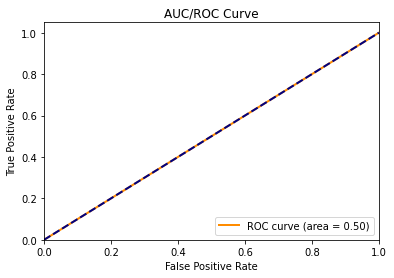

In [31]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC/ROC Curve')
plt.legend(loc="lower right")
plt.show()